In [159]:
import os
import pickle as pkl
import sys
import numpy as np
import pandas as pd
import sklearn
import csv
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import MDS
import seaborn as sns
import ot
import plotly.graph_objs as go
import plotly.express as px
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [256]:
# Define unique colors
unique_colours = np.array(["#d2b700", "#db8b08", "#c7512c", "#c13547", "#a03663", "#753a7a", "#4b488e", "#005692", "#006a8b", "#007b75", "#008a52", "#9aa400"])
colour_index = {colour: idx for idx, colour in enumerate(unique_colours)}
matrix_size = len(unique_colours)

### configuration
n_eps = 7 # number of epsilon values tried
eps_range = [0.04, 5] # the range of epsilon searched
epsilons = np.logspace(np.log10(eps_range[0]), np.log10(eps_range[1]), n_eps) # epsilon values

In [252]:
def add_colored_label(ax, x, y, bgcolor, width=1, height=1):
  rect = Rectangle((x, y), width, height, facecolor=bgcolor)
  ax.add_patch(rect)
  
def show_heatmaps(vmin_val, vmax_val, matrices, titles, cbar_label=None, color_labels=None):
    num_plots = len(matrices)
    fig, axs = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))

    if num_plots == 1:
        axs = [axs]

    for i, (matrix, title) in enumerate(zip(matrices, titles)):
        ax = axs[i]
        
        im = ax.imshow(matrix, aspect='auto', vmin=vmin_val, vmax=vmax_val)
        ax.set_title(title)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(im, cax=cax)
        cbar.set_label(cbar_label)

        # Adjust the height of the color bar
        position = cax.get_position()
        new_position = [position.x0, position.y0 + 0.1, position.width, position.height * 0.8]
        cax.set_position(new_position)

        if color_labels is not None:
            ax.axis('off')
            for idx, color in enumerate(color_labels):
                add_colored_label(ax, -1.5, idx-0.5, color, width=0.8)
                add_colored_label(ax, idx-0.5, matrix.shape[1] - 0.2, color, height=0.8)

            ax.set_aspect('equal')
            ax.set_xlim(-3.0, matrix.shape[1])
            ax.set_ylim(-1, len(color_labels)+1.4)
            ax.invert_yaxis()

            for spine in ax.spines.values():
                spine.set_visible(False)

    plt.tight_layout()
    plt.show()


def transform_value(value):
    return -value + 3.5

def RSA(matrix1, matrix2, method='pearson'):
  upper_tri_1 = matrix1[np.triu_indices(matrix1.shape[0], k=1)]
  upper_tri_2 = matrix2[np.triu_indices(matrix2.shape[0], k=1)]
  if method == 'pearson':
    corr, _ = pearsonr(upper_tri_1, upper_tri_2)
  elif method == 'spearman':
    corr, _ = spearmanr(upper_tri_1, upper_tri_2)

  return corr

def comp_matching_rate(OT_plan, k, order="maximum"):
  # This function computes the matching rate, assuming that in the optimal transportation plan,
  # the items in the i-th row and the j-th column are the same (correct mactch) when i = j.
  # Thus, the diagonal elements of the optimal transportation plan represent the probabilities
  # that the same items (colors) match between the two structures.

  # Get the diagonal elements
  diagonal = np.diag(OT_plan)
  # Get the top k values for each row
  if order == "maximum":
      topk_values = np.partition(OT_plan, -k)[:, -k:]
  elif order == "minimum":
      topk_values = np.partition(OT_plan, k - 1)[:, :k]
  # Count the number of rows where the diagonal is in the top k values and compute the matching rate
  count = np.sum([diagonal[i] in topk_values[i] for i in range(OT_plan.shape[0])])
  matching_rate = count / OT_plan.shape[0] * 100
  return matching_rate

# Function to plot the embeddings
def plot_embeddings(embeddings, titles, color_labels, overlay=False):
    fig = go.Figure()
    
    if overlay:
        for i, embedding in enumerate(embeddings):
            fig.add_trace(go.Scatter3d(
                x=embedding[:, 0],
                y=embedding[:, 1],
                z=embedding[:, 2],
                mode='markers+text',
                marker=dict(size=10, color=color_labels),
                text=color_labels,
                textposition="top center",
                name=titles[i]
            ))
    else:
        for i, embedding in enumerate(embeddings):
            fig = go.Figure()
            fig.add_trace(go.Scatter3d(
                x=embedding[:, 0],
                y=embedding[:, 1],
                z=embedding[:, 2],
                mode='markers+text',
                marker=dict(size=10, color=color_labels),
                text=color_labels,
                textposition="top center"
            ))
            fig.update_layout(
                title=f'MDS Embedding - {titles[i]}',
                scene=dict(
                    xaxis_title='Dimension 1',
                    yaxis_title='Dimension 2',
                    zaxis_title='Dimension 3'
                ),
                height=800
            )
    fig.show()

# Define the function to compute GWD
def compute_min_gwd(matrix_1, matrix_2, epsilons):

    OT_plans = []
    gwds = []
    matching_rates = []

    for epsilon in epsilons:
      OT, gw_log = ot.gromov.entropic_gromov_wasserstein(C1=matrix_1, C2=matrix_2 , epsilon=epsilon, loss_fun="square_loss", log=True)  # optimization
      gwd = gw_log['gw_dist']
      matching_rate = comp_matching_rate(OT, k=1)  # calculate the top 1 matching rate
      OT_plans.append(OT)
      gwds.append(gwd)
      matching_rates.append(matching_rate)

    return min(gwds)

def GWD_and_plot(matrix1, matrix2, epsilons):
    
    OT_plans = []
    gwds = []
    matching_rates = []

    for epsilon in epsilons:
      OT, gw_log = ot.gromov.entropic_gromov_wasserstein(C1=matrix1, C2=matrix2 , epsilon=epsilon, loss_fun="square_loss", log=True)  # optimization
      gwd = gw_log['gw_dist']
      matching_rate = comp_matching_rate(OT, k=1)  # calculate the top 1 matching rate
      OT_plans.append(OT)
      gwds.append(gwd)
      matching_rates.append(matching_rate)

      
    plt.scatter(epsilons, gwds, c=matching_rates)
    plt.xlabel("epsilon")
    plt.ylabel("GWD")
    plt.xscale('log')
    plt.grid(True, which = 'both')
    cbar = plt.colorbar()
    cbar.set_label(label='Matching Rate (%)')
    plt.show()

    # extract the best epsilon that minimizes the GWD
    min_gwd = min(gwds)
    best_eps_idx = gwds.index(min_gwd)
    best_eps = epsilons[best_eps_idx]
    OT_plan = OT_plans[best_eps_idx]
    matching_rate = matching_rates[best_eps_idx]

    show_heatmaps(0, 0.1, matrices=[OT_plan], titles=[f'Optimal transportation plan \n GWD={min_gwd:.3f} \n matching rate : {matching_rate:.1f}%'])


def OT_epsilon(epsilons, OT_plans, gwds, e_ind, matching_rates):

    best_eps_idx = e_ind
    min_gwd = gwds[best_eps_idx]
    best_eps = epsilons[best_eps_idx]
    OT_plan = OT_plans[best_eps_idx]
    matching_rate = matching_rates[best_eps_idx]

    show_heatmaps(0, 0.05,
        matrices=[OT_plan],
        titles=[f'Optimal transportation plan \n GWD={min_gwd:.3f} \n matching rate : {matching_rate:.1f}%'],
        color_labels=unique_colours)
    
# Define the function to shuffle the matrix
def shuffle_upper_triangular_and_asymmetritisize(matrix, size):
    matrix_copy = matrix.copy()
    # Set the diagonal elements to zero
    np.fill_diagonal(matrix_copy, 0)

    # Shuffle the upper triangular elements
    upper_tri_indices = np.triu_indices(size, 1)
    upper_tri_values = matrix_copy[upper_tri_indices].copy()
    np.random.shuffle(upper_tri_values)
    matrix_copy[upper_tri_indices] = upper_tri_values
    
    # Set the lower triangular part of the matrix to the negative of the upper triangular part
    for i in range(size):
        for j in range(i + 1, size):
            matrix_copy[j, i] = -matrix_copy[i, j]
    
    return matrix_copy

# Shuffle elements across rows except the diagonal elements
def shuffle_column_and_asymmetritisize(matrix, size):
    matrix_copy = matrix.copy()
    np.fill_diagonal(matrix_copy, 0)

    # Set the lower triangular part of the matrix to the negative of the upper triangular part
    for i in range(size):
        for j in range(i + 1, size):
            matrix_copy[j, i] = -matrix_copy[i, j]

    for i in range(size):
        non_diag_indices = [j for j in range(matrix_size) if j != i]
        non_diag_values = matrix_copy[non_diag_indices, i].copy()
        np.random.shuffle(non_diag_values)
        matrix_copy[non_diag_indices, i] = non_diag_values
    
    return matrix_copy

In [162]:
# Create matrix
matrix_1 = np.zeros((matrix_size, matrix_size))
matrix_2 = np.zeros((matrix_size, matrix_size))

# Load the second CSV file
df_PM1 = pd.read_csv('617663_kana_colourPreferenceQualia_2024-06-25_14h38.37.490.csv')

# Extract columns
colour1_1 = df_PM1['colour1']
colour2_1 = df_PM1['colour2']
target_preference_1 = df_PM1['target_preference']

# Fill the matrix
for c1, c2, tp in zip(colour1_1, colour2_1, target_preference_1):
    I = colour_index[c1]
    j = colour_index[c2]
    matrix_1[I, j] = tp

# Load the second CSV file
df_PM2 = pd.read_csv('348000_kana_colourPreferenceQualia_2024-06-25_17h18.18.443.csv')

# Extract columns
colour1_2 = df_PM2['colour1']
colour2_2 = df_PM2['colour2']
target_preference_2 = df_PM2['target_preference']

# Fill the matrix
for c1, c2, tp in zip(colour1_2, colour2_2, target_preference_2):
    I = colour_index[c1]
    j = colour_index[c2]
    matrix_2[I, j] = tp


# No Value Mapping - asymmetric

In [163]:
matrix_1_copy = matrix_1.copy()

# Set the diagonal elements to zero
np.fill_diagonal(matrix_1_copy, np.nan)

no_value_mapping_1 = matrix_1_copy

# Set the lower triangular part of the matrix to NaN
lower_tri_indices = np.tril_indices(matrix_size, -1)
no_value_mapping_1[lower_tri_indices] = np.nan

# Convert to DataFrame for better readability
no_value_mapping_1_df = pd.DataFrame(no_value_mapping_1, index=unique_colours, columns=unique_colours)

In [164]:
matrix_2_copy = matrix_2.copy()

# Set the diagonal elements to NaN
np.fill_diagonal(matrix_2_copy, np.nan)

no_value_mapping_2 = matrix_2_copy

# Set the lower triangular part of the matrix to NaN
lower_tri_indices = np.tril_indices(matrix_size, -1)
no_value_mapping_2[lower_tri_indices] = np.nan

# Convert to DataFrame for better readability
no_value_mapping_2_df = pd.DataFrame(no_value_mapping_2, index=unique_colours, columns=unique_colours)

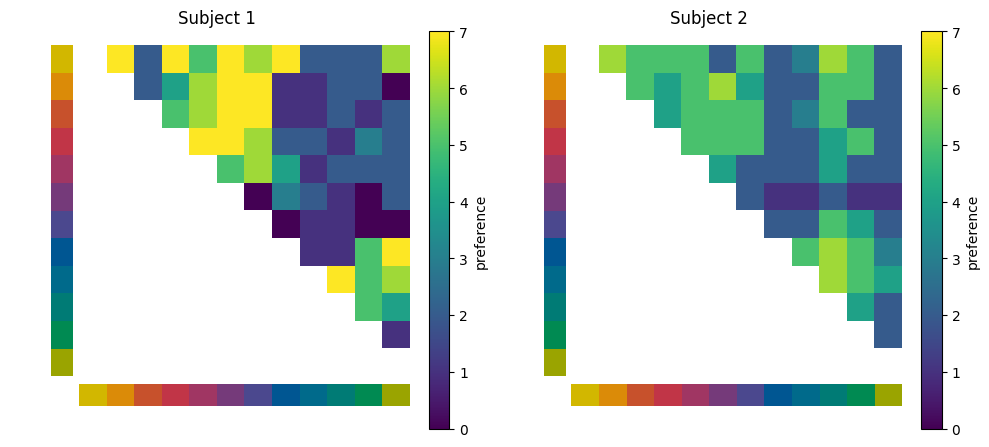

In [165]:
show_heatmaps(0, 7, matrices=[no_value_mapping_1, no_value_mapping_2], titles=['Subject 1', 'Subject 2'], cbar_label="preference", color_labels=unique_colours)

# No Value Mapping - symmetric

In [166]:
# Calculate the transpose of the matrix
matrix_1_transpose = matrix_1.T

# Sum the original matrix and its transpose
matrix_sum_1 = matrix_1 + matrix_1_transpose

# Set the diagonal elements to zero
np.fill_diagonal(matrix_sum_1, 0)

no_value_mapping_1_sym = matrix_sum_1

# Convert to DataFrame for better readability
no_value_mapping_1_sym_df = pd.DataFrame(no_value_mapping_1_sym, index=unique_colours, columns=unique_colours)

In [167]:
# Calculate the transpose of the matrix
matrix_2_transpose = matrix_2.T

# Sum the original matrix and its transpose
matrix_sum_2 = matrix_2 + matrix_2_transpose

# Set the diagonal elements to zero
np.fill_diagonal(matrix_sum_2, 0)

no_value_mapping_2_sym = matrix_sum_2

# Convert to DataFrame for better readability
matrix_transformed_2_sym_df = pd.DataFrame(no_value_mapping_2_sym, index=unique_colours, columns=unique_colours)

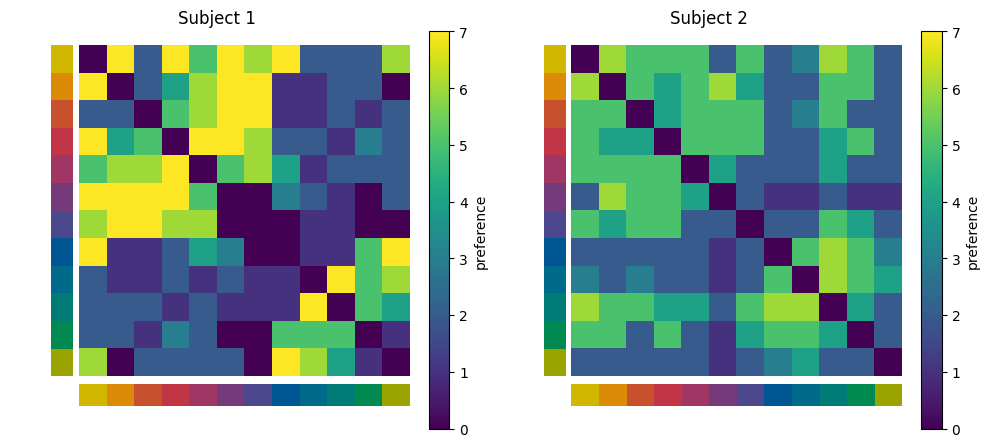

In [168]:
show_heatmaps( 0, 7, matrices=[no_value_mapping_1_sym, no_value_mapping_2_sym], titles=['Subject 1', 'Subject 2'], cbar_label="preference", color_labels=unique_colours)

# Value Mapping to -3.5 ~ 3.5 - raw matrix

In [169]:
# Apply the transformation rule to the entire matrix
value_mapped_raw_1 = np.vectorize(transform_value)(matrix_1)

# Set the diagonal elements to zero
np.fill_diagonal(value_mapped_raw_1, np.nan)

# Set the lower triangular part of the matrix to NaN
lower_tri_indices = np.tril_indices(matrix_size, -1)
value_mapped_raw_1[lower_tri_indices] = np.nan

# Convert to DataFrame for better readability
value_mapped_raw_1_df = pd.DataFrame(value_mapped_raw_1, index=unique_colours, columns=unique_colours)

In [170]:
# Apply the transformation rule to the entire matrix
value_mapped_raw_2 = np.vectorize(transform_value)(matrix_2)

# Set the diagonal elements to zero
np.fill_diagonal(value_mapped_raw_2, np.nan)

# Set the lower triangular part of the matrix to NaN
lower_tri_indices = np.tril_indices(matrix_size, -1)
value_mapped_raw_2[lower_tri_indices] = np.nan

# Convert to DataFrame for better readability
value_mapped_raw_2_df = pd.DataFrame(value_mapped_raw_2, index=unique_colours, columns=unique_colours)

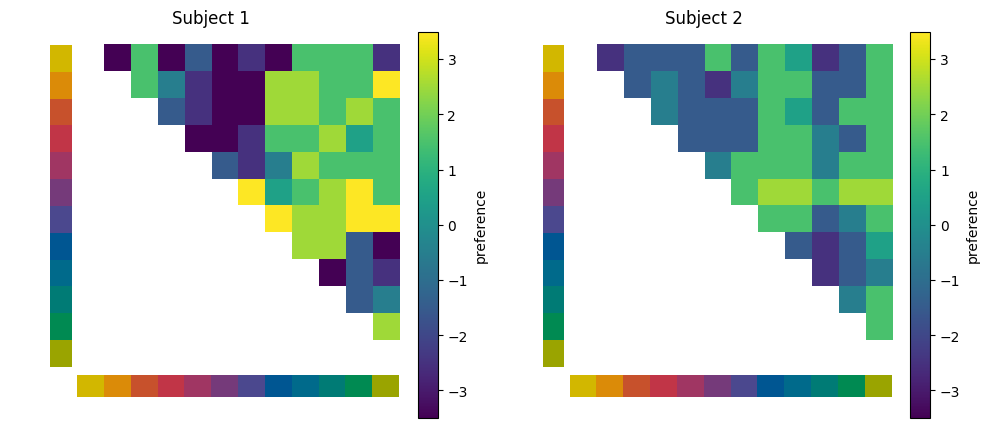

In [171]:
show_heatmaps(-3.5, 3.5, matrices=[value_mapped_raw_1, value_mapped_raw_2], titles=['Subject 1', 'Subject 2'], cbar_label="preference", color_labels=unique_colours)

# Value Mapping to -3.5 ~ 3.5 - assymetric matrix/opposite

In [172]:
# Apply the transformation rule to the entire matrix
value_mapped_as_1 = np.vectorize(transform_value)(matrix_1)

# Set the diagonal elements to zero
np.fill_diagonal(value_mapped_as_1, 0)

# Set the lower triangular part of the matrix to the negative of the upper triangular part
for i in range(matrix_size):
    for j in range(i+1, matrix_size):
        value_mapped_as_1[j, i] = -value_mapped_as_1[i, j]

# Convert to DataFrame for better readability
value_mapped_as_1_df = pd.DataFrame(value_mapped_as_1, index=unique_colours, columns=unique_colours)

In [173]:
# Apply the transformation rule to the entire matrix
value_mapped_as_2 = np.vectorize(transform_value)(matrix_2)

# Set the diagonal elements to zero
np.fill_diagonal(value_mapped_as_2, 0)

# Set the lower triangular part of the matrix to the negative of the upper triangular part
for i in range(matrix_size):
    for j in range(i+1, matrix_size):
        value_mapped_as_2[j, i] = -value_mapped_as_2[i, j]

# Convert to DataFrame for better readability
value_mapped_as_2_df = pd.DataFrame(value_mapped_as_2, index=unique_colours, columns=unique_colours)

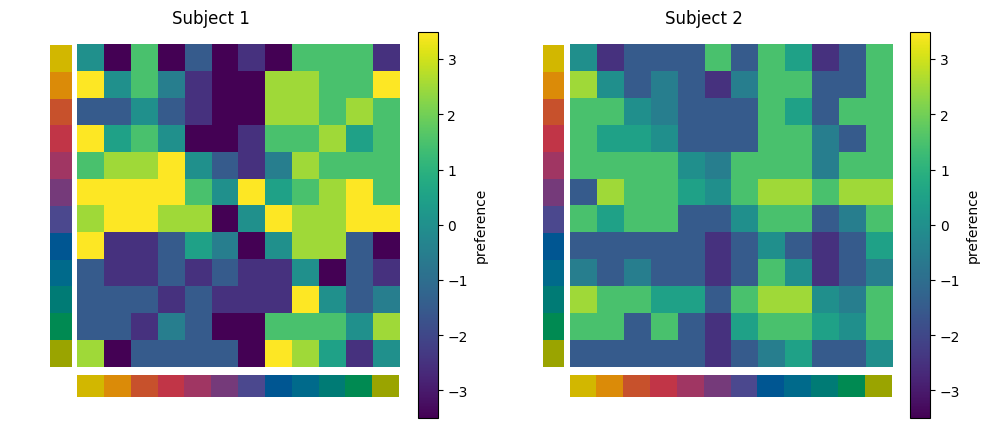

In [174]:
show_heatmaps(-3.5, 3.5, matrices=[value_mapped_as_1, value_mapped_as_2], titles=['Subject 1', 'Subject 2'], cbar_label="preference", color_labels=unique_colours)

# Value Mapping to -3.5 - 3.5 - symmetrical

In [175]:
# Calculate the transpose of the matrix
matrix_1_transpose = matrix_1.T

# Sum the original matrix and its transpose
matrix_sum_1 = matrix_1 + matrix_1_transpose

# Apply the transformation rule to the entire matrix
value_mapped_sym_1 = np.vectorize(transform_value)(matrix_sum_1)

# Set the diagonal elements to zero
np.fill_diagonal(value_mapped_sym_1, 0)

# Convert to DataFrame for better readability
value_mapped_sym_1_df = pd.DataFrame(value_mapped_sym_1, index=unique_colours, columns=unique_colours)

In [176]:
# Calculate the transpose of the matrix
matrix_2_transpose = matrix_2.T

# Sum the original matrix and its transpose
matrix_sum_2 = matrix_2 + matrix_2_transpose

# Apply the transformation rule to the entire matrix
value_mapped_sym_2 = np.vectorize(transform_value)(matrix_sum_2)

# Set the diagonal elements to zero
np.fill_diagonal(value_mapped_sym_2, 0)

# Convert to DataFrame for better readability
value_mapped_sym_2_df = pd.DataFrame(value_mapped_sym_2, index=unique_colours, columns=unique_colours)

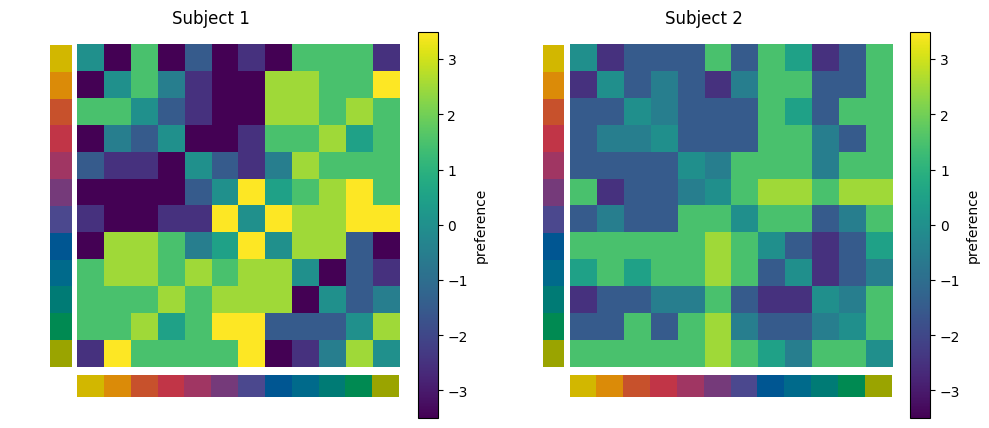

In [177]:
show_heatmaps(-3.5, 3.5, matrices=[value_mapped_sym_1, value_mapped_sym_2], titles=['Subject 1', 'Subject 2'], cbar_label="preference", color_labels=unique_colours)

# MDS

### 1D DMS and overall preference rating

In [178]:
def plot_1DMDS_overallPreference(matrix_transformed_1, matrix_transformed_2, matrix_transformed_1_as, matrix_transformed_2_as, unique_colours):
    embeddings = []
    for RDM in [matrix_transformed_1, matrix_transformed_2]:
        mds = MDS(n_components=1, dissimilarity='precomputed', random_state=5)
        embedding = mds.fit_transform(RDM)
        embeddings.append(embedding)

    row_averages_1 = matrix_transformed_1_as.mean(axis=0).reshape(-1, 1)
    embeddings_1 = np.hstack((embeddings[0], row_averages_1))

    row_averages_2 = matrix_transformed_2_as.mean(axis=0).reshape(-1, 1)
    embeddings_2 = np.hstack((embeddings[1], row_averages_2))

    embeddings_3 = [embeddings_1, embeddings_2]

    # Plot the embeddings
    plt.figure(figsize=(12, 6))

    # Plot the first embedding
    plt.subplot(1, 2, 1)
    plt.scatter(embeddings_3[0][:, 0], embeddings_3[0][:, 1], color=unique_colours)
    for i, color in enumerate(unique_colours):
        plt.text(embeddings_3[0][i, 0], embeddings_3[0][i, 1], color, fontsize=12, color=color)
    plt.title('MDS Embedding - Subject 1')
    plt.xlabel('MDS Dimension 1', fontsize=14)
    plt.ylabel('Overall Preference value', fontsize=14)

    # Plot the second embedding
    plt.subplot(1, 2, 2)
    plt.scatter(embeddings_3[1][:, 0], embeddings_3[1][:, 1], color=unique_colours)
    for i, color in enumerate(unique_colours):
        plt.text(embeddings_3[1][i, 0], embeddings_3[1][i, 1], color, fontsize=12, color=color)
    plt.title('MDS Embedding - Subject 2')
    plt.xlabel('MDS Dimension 1', fontsize=14)
    plt.ylabel('Overall Preference value', fontsize=14)

    plt.tight_layout()
    plt.show()

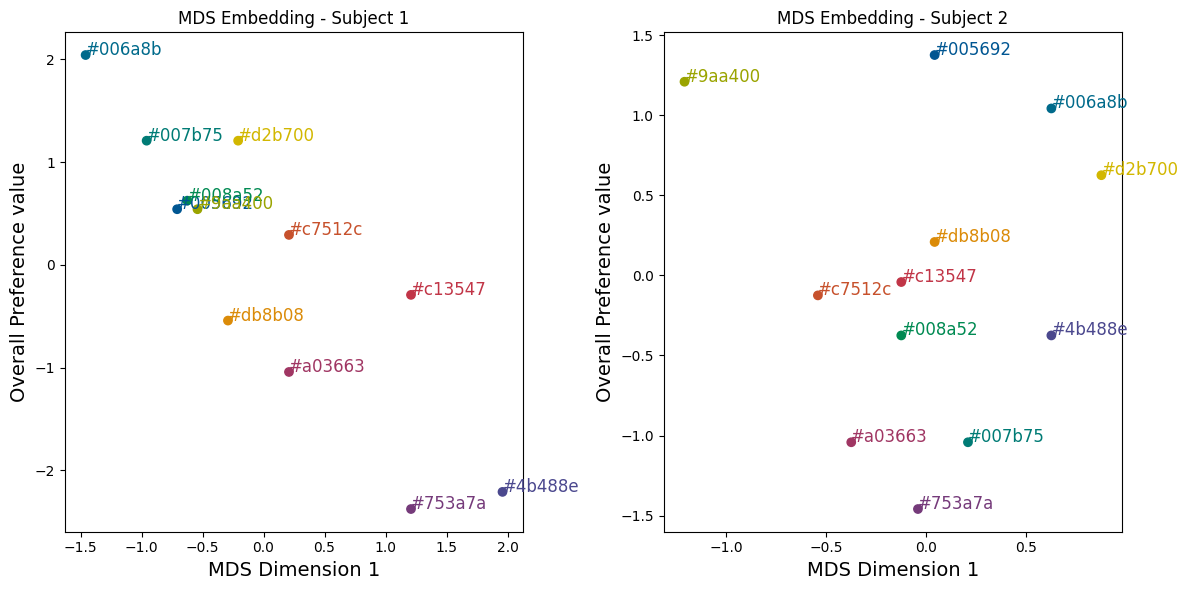

In [179]:
plot_1DMDS_overallPreference(value_mapped_sym_1, value_mapped_sym_2, value_mapped_as_1, value_mapped_as_2, unique_colours)

### 3D MDS

In [180]:
def plot_3D_embeddings(embeddings, titles, color_labels, overlay=False):

    if overlay:
        fig = go.Figure()
        for i, embedding in enumerate(embeddings):
            fig.add_trace(go.Scatter3d(
                x=embedding[:, 0],
                y=embedding[:, 1],
                z=embedding[:, 2],
                mode='markers+text',
                marker=dict(size=10, color=color_labels),
                text=color_labels,
                textposition="top center",
                name=titles[i]
            ))
        fig.update_layout(
            title='Overlayed MDS Embeddings',
            scene=dict(
                xaxis_title='Dimension 1',
                yaxis_title='Dimension 2',
                zaxis_title='Dimension 3'
            ),
            height=800,
            plot_bgcolor='white'
        )
        fig.show()
    else:
        for i, embedding in enumerate(embeddings):
            fig = go.Figure()
            fig.add_trace(go.Scatter3d(
                x=embedding[:, 0],
                y=embedding[:, 1],
                z=embedding[:, 2],
                mode='markers+text',
                marker=dict(size=10, color=color_labels),
                text=color_labels,
                textposition="top center"
            ))
            fig.update_layout(
                title=f'MDS Embedding - {titles[i]}',
                scene=dict(
                    xaxis_title='Dimension 1',
                    yaxis_title='Dimension 2',
                    zaxis_title='Dimension 3'
                ),
                height=800,
                plot_bgcolor='white'
            )
            fig.show()


def plot_3DMDS(matrix_transformed_1, matrix_transformed_2, titles, color_labels, overlay=False):
    # Compute MDS for each transformed matrix
    embeddings = []
    for RDM in [matrix_transformed_1, matrix_transformed_2]:
        mds = MDS(n_components=3, dissimilarity='precomputed', random_state=5)
        embedding = mds.fit_transform(RDM)
        embeddings.append(embedding)

    plot_3D_embeddings(embeddings, titles, color_labels, overlay=False)

In [181]:
# Plot the embeddings
plot_3DMDS(value_mapped_sym_1, value_mapped_sym_2, titles=['Subject 1', 'Subject 2'], color_labels=unique_colours, overlay=False)

### 2D MDS

In [182]:
def plot_2DMDS(matrix_transformed_1, matrix_transformed_2):
    # List to store the embeddings
    embeddings = []

    # Compute MDS for each transformed matrix
    for RDM in [matrix_transformed_1, matrix_transformed_2]:
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=5)
        embedding = mds.fit_transform(RDM)
        embeddings.append(embedding)

    # Define unique colors
    unique_colours = np.array(["#d2b700", "#db8b08", "#c7512c", "#c13547", "#a03663", "#753a7a", "#4b488e", "#005692", "#006a8b", "#007b75", "#008a52", "#9aa400"])

    # Plot the embeddings
    plt.figure(figsize=(12, 6))

    # Plot the first embedding
    plt.subplot(1, 2, 1)
    plt.scatter(embeddings[0][:, 0], embeddings[0][:, 1], color=unique_colours)
    for i, color in enumerate(unique_colours):
        plt.text(embeddings[0][i, 0], embeddings[0][i, 1], color, fontsize=12, color=color)
    plt.title('MDS Embedding - Subject 1')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    # Plot the second embedding
    plt.subplot(1, 2, 2)
    plt.scatter(embeddings[1][:, 0], embeddings[1][:, 1], color=unique_colours)
    for i, color in enumerate(unique_colours):
        plt.text(embeddings[1][i, 0], embeddings[1][i, 1], color, fontsize=12, color=color)
    plt.title('MDS Embedding - Subject 2')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    plt.tight_layout()
    plt.show()

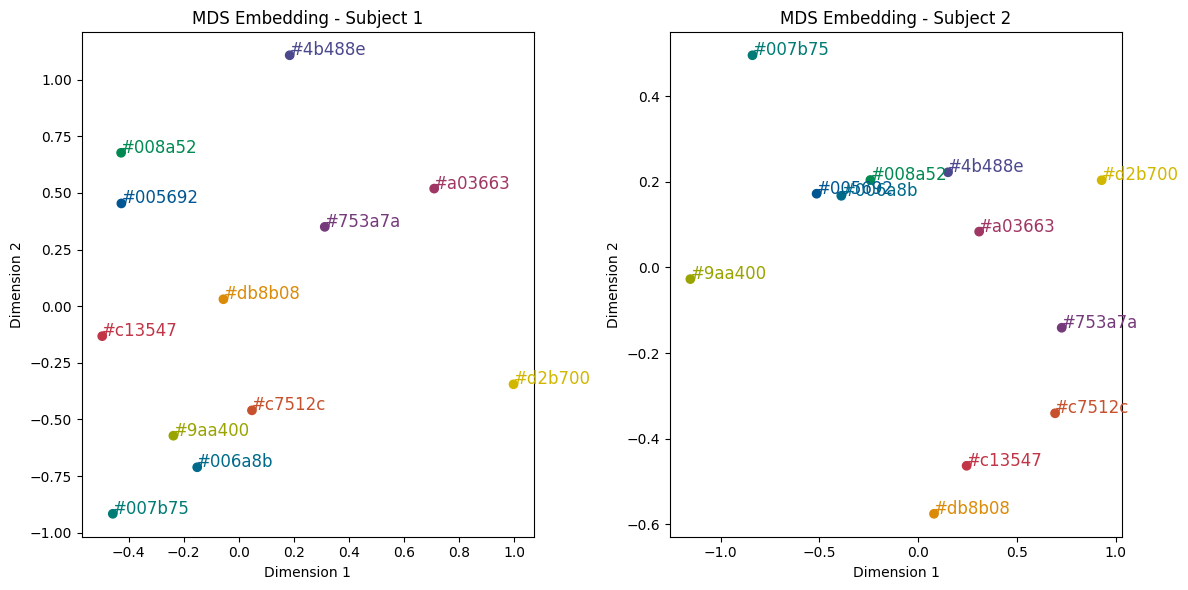

In [183]:
plot_2DMDS(value_mapped_sym_1, value_mapped_sym_2)

### 3D MDS with preference as the z-axis

In [184]:
def plot_3DMDS_overallPreference(matrix_transformed_1, matrix_transformed_2, matrix_transformed_1_as, matrix_transformed_2_as, unique_colours):
    # List to store the embeddings
    embeddings = []

    # First matrix
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=5)
    embedding_2d = mds.fit_transform(matrix_transformed_1)

    # Calculate the average value for each column
    row_averages_1 = matrix_transformed_1_as.mean(axis=0).reshape(-1, 1)

    # Add the row averages as the third dimension
    embedding_3d = np.hstack((embedding_2d, row_averages_1))
    embeddings.append(embedding_3d)

    # Second matrix
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=5)
    embedding_2d = mds.fit_transform(matrix_transformed_2)

    # Calculate the average value for each row
    row_averages_2 = matrix_transformed_2_as.mean(axis=0).reshape(-1, 1)

    # Add the row averages as the third dimension
    embedding_3d = np.hstack((embedding_2d, row_averages_2))
    embeddings.append(embedding_3d)

    plot_3D_embeddings(embeddings, titles=['Subject 1', 'Subject 2'], color_labels=unique_colours, overlay=False)

In [185]:
plot_3DMDS_overallPreference(value_mapped_sym_1, value_mapped_sym_2, value_mapped_as_1, value_mapped_as_2, unique_colours)

# GWOT

### GWOT with symmetric matrix (preference distance)

RSA correlation coefficient :  0.42451626289800193


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning:

Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.



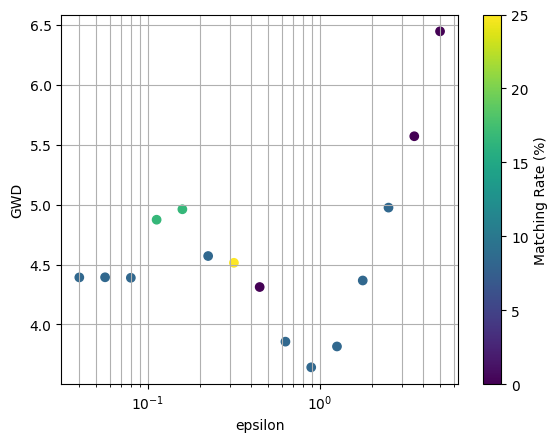

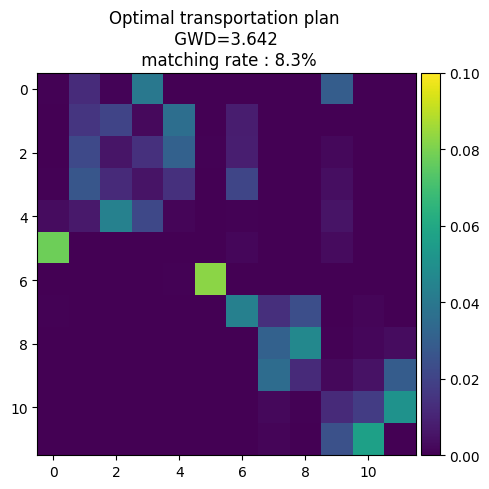

In [125]:
RSA_corr = RSA(value_mapped_sym_1, value_mapped_sym_2)
print('RSA correlation coefficient : ', RSA_corr)
GWD_and_plot(value_mapped_sym_1, value_mapped_sym_2, epsilons)

### GWOT with asymmetric matrix (preference ratings)

RSA correlation coefficient :  0.42451626289800193


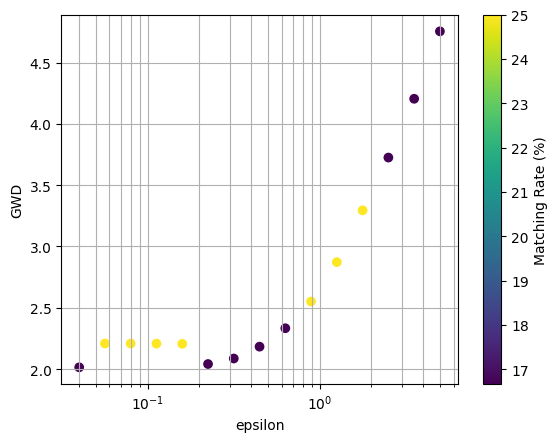

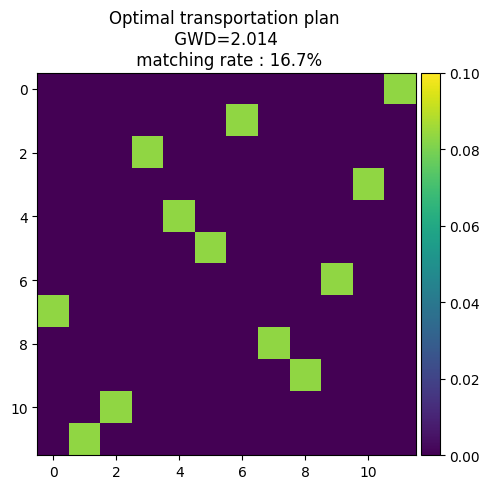

In [126]:
RSA_corr = RSA(value_mapped_as_1, value_mapped_as_2)
print('RSA correlation coefficient : ', RSA_corr)
GWD_and_plot(value_mapped_as_1, value_mapped_as_2, epsilons)

### GWOT with random matrix - triangular based

#### Kana

In [193]:
value_mapped_as_shuffledByDiagonal_1 = shuffle_upper_triangular_and_asymmetritisize(value_mapped_raw_1, matrix_size)

RSA correlation coefficient :  0.012556772642265589


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning:

Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.



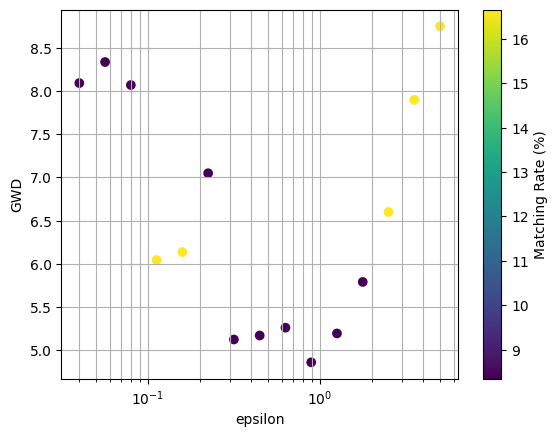

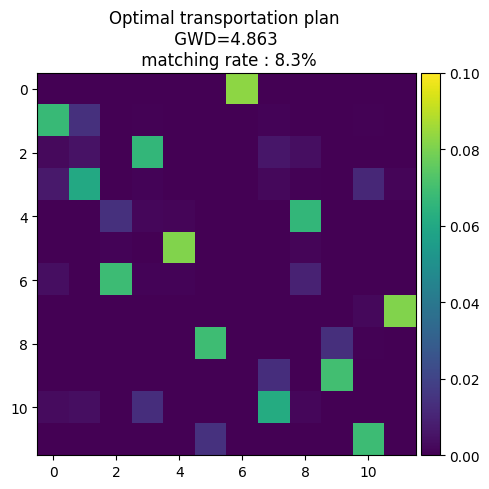

In [144]:
RSA_corr = RSA(value_mapped_as_1, value_mapped_as_shuffledByDiagonal_1)
print('RSA correlation coefficient : ', RSA_corr)
GWD_and_plot(value_mapped_as_1, value_mapped_as_shuffledByDiagonal_1, epsilons)

#### Angus

In [147]:
value_mapped_as_shuffledByDiagonal_2 = shuffle_upper_triangular_and_asymmetritisize(value_mapped_raw_2, matrix_size)

RSA correlation coefficient :  -0.13014016656714772


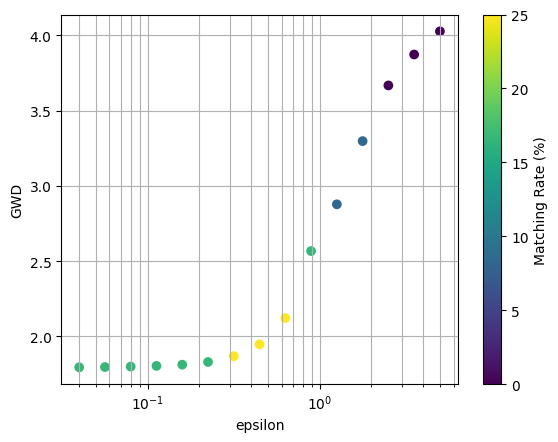

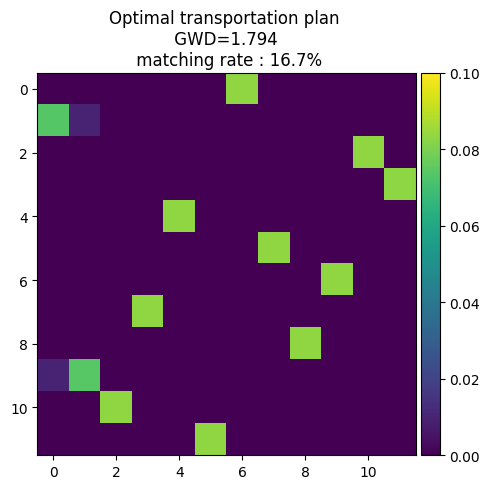

In [148]:
RSA_corr = RSA(value_mapped_as_1, value_mapped_as_shuffledByDiagonal_2)
print('RSA correlation coefficient : ', RSA_corr)
GWD_and_plot(value_mapped_as_2, value_mapped_as_shuffledByDiagonal_2, epsilons)

### GWOT with random matrix - column based

#### Kana

In [198]:
value_mapped_as_shuffledByColumn_1 = shuffle_column_and_asymmetritisize(value_mapped_raw_1, matrix_size)

RSA correlation coefficient :  0.42702063416388886


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning:

Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.



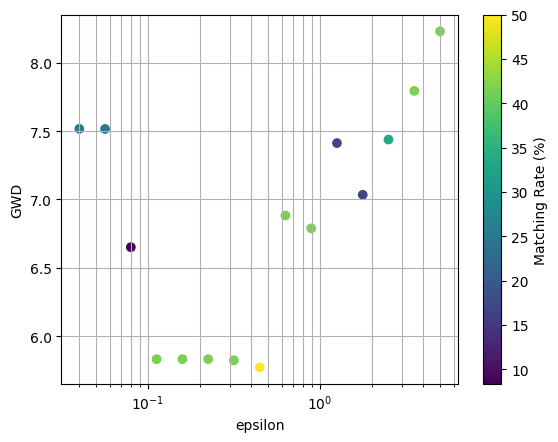

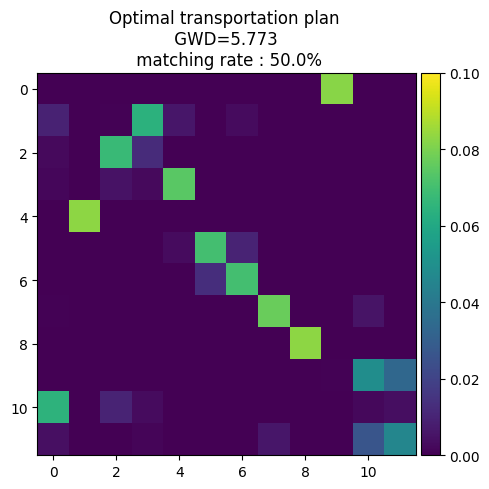

In [152]:
RSA_corr = RSA(value_mapped_as_1, value_mapped_as_shuffledByColumn_1)
print('RSA correlation coefficient : ', RSA_corr)
GWD_and_plot(value_mapped_as_1, value_mapped_as_shuffledByColumn_1, epsilons)

#### Angus

In [153]:
value_mapped_as_shuffledByColumn_2 = shuffle_column_and_asymmetritisize(value_mapped_raw_2, matrix_size)

RSA correlation coefficient :  0.27942604598813964


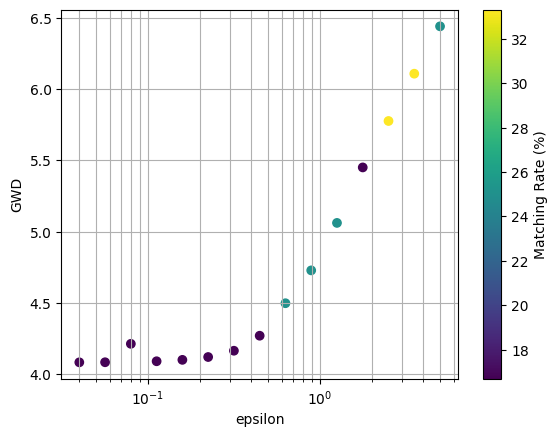

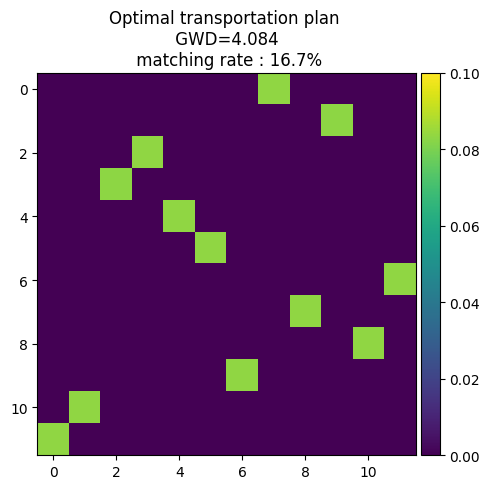

In [154]:
RSA_corr = RSA(value_mapped_as_2, value_mapped_as_shuffledByColumn_2)
print('RSA correlation coefficient : ', RSA_corr)
GWD_and_plot(value_mapped_as_2, value_mapped_as_shuffledByColumn_2, epsilons)

### GWOT with random matrix - shuffled and shuffled (diagonal based)

#### Kana

In [155]:
value_mapped_as_shuffledByDiagonal_1_1 = shuffle_upper_triangular_and_asymmetritisize(value_mapped_raw_1, matrix_size)
value_mapped_as_shuffledByDiagonal_1_2 = shuffle_upper_triangular_and_asymmetritisize(value_mapped_raw_1, matrix_size)

RSA correlation coefficient :  -0.012633105606656238


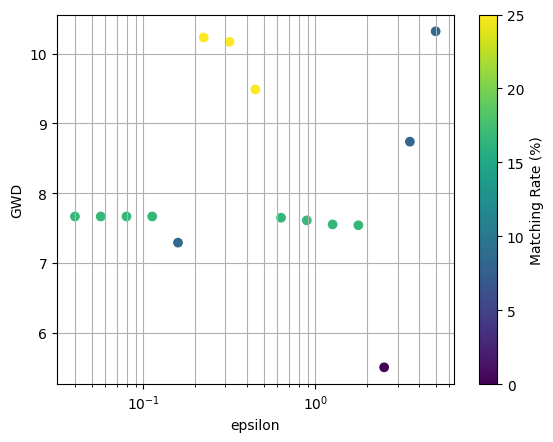

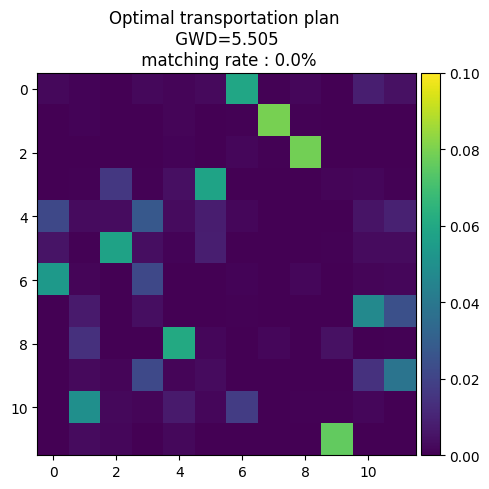

In [156]:
RSA_corr = RSA(value_mapped_as_shuffledByDiagonal_1_1, value_mapped_as_shuffledByDiagonal_1_2)
print('RSA correlation coefficient : ', RSA_corr)
GWD_and_plot(value_mapped_as_shuffledByDiagonal_1_1, value_mapped_as_shuffledByDiagonal_1_2, epsilons)

#### Angus

In [157]:
value_mapped_as_shuffledByDiagonal_2_1 = shuffle_upper_triangular_and_asymmetritisize(value_mapped_raw_2, matrix_size)
value_mapped_as_shuffledByDiagonal_2_2 = shuffle_upper_triangular_and_asymmetritisize(value_mapped_raw_2, matrix_size)

RSA correlation coefficient :  0.009252265861027184


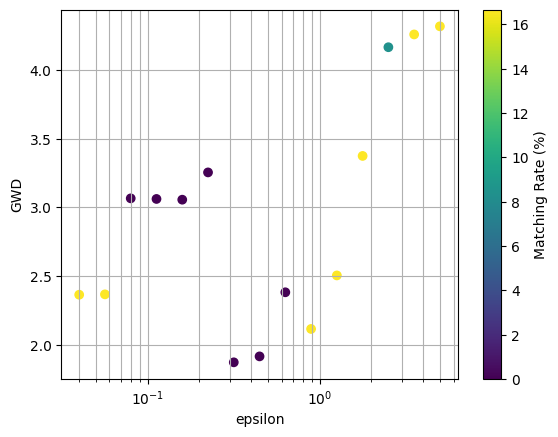

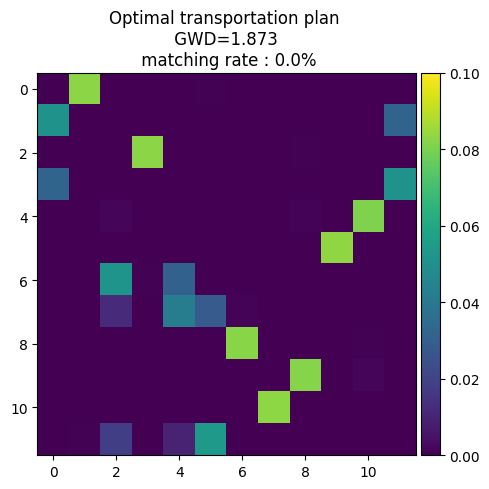

In [158]:
RSA_corr = RSA(value_mapped_as_shuffledByDiagonal_2_1, value_mapped_as_shuffledByDiagonal_2_2)
print('RSA correlation coefficient : ', RSA_corr)
GWD_and_plot(value_mapped_as_shuffledByDiagonal_2_1, value_mapped_as_shuffledByDiagonal_2_2, epsilons)

### GWOT with random matrix - shuffled and shuffled (column based)

#### Kana

In [201]:
value_mapped_as_shuffledByColumn_1_1 = shuffle_column_and_asymmetritisize(value_mapped_raw_1, matrix_size)
value_mapped_as_shuffledByColumn_1_2 = shuffle_column_and_asymmetritisize(value_mapped_raw_1, matrix_size)

RSA correlation coefficient :  0.44240232351020464


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning:

Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.



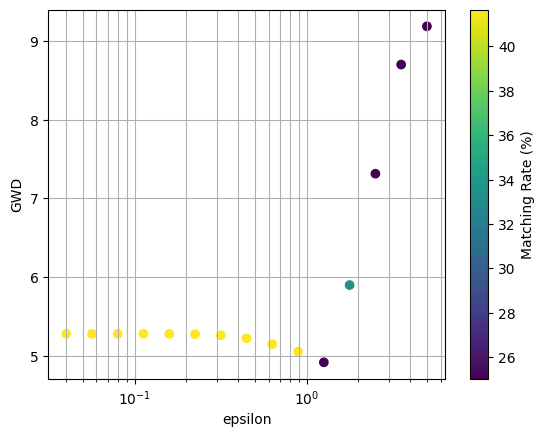

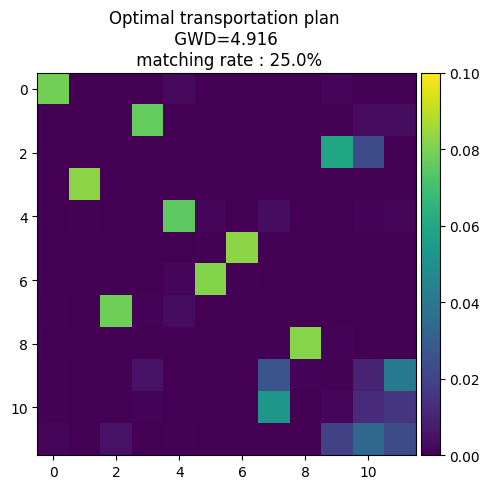

In [202]:
RSA_corr = RSA(value_mapped_as_shuffledByColumn_1_1, value_mapped_as_shuffledByColumn_1_2)
print('RSA correlation coefficient : ', RSA_corr)
GWD_and_plot(value_mapped_as_shuffledByDiagonal_1_1, value_mapped_as_shuffledByDiagonal_1_2, epsilons)

#### Angus

In [203]:
value_mapped_as_shuffledByColumn_2_1 = shuffle_column_and_asymmetritisize(value_mapped_raw_2, matrix_size)
value_mapped_as_shuffledByColumn_2_2 = shuffle_column_and_asymmetritisize(value_mapped_raw_2, matrix_size)

RSA correlation coefficient :  0.23037104445738338


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning:

Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.



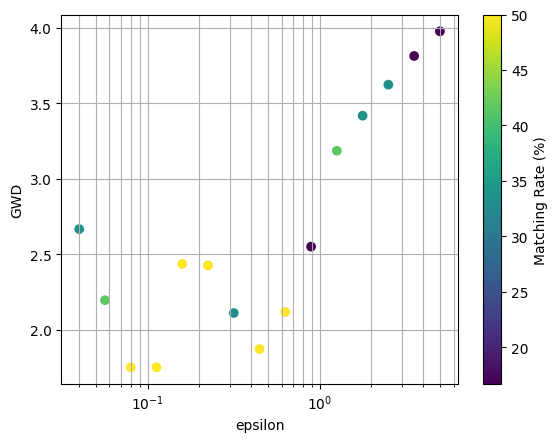

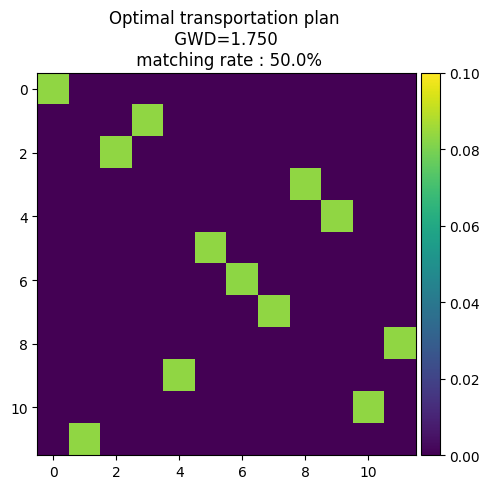

In [204]:
RSA_corr = RSA(value_mapped_as_shuffledByColumn_2_1, value_mapped_as_shuffledByColumn_2_2)
print('RSA correlation coefficient : ', RSA_corr)
GWD_and_plot(value_mapped_as_shuffledByColumn_2_1, value_mapped_as_shuffledByColumn_2_2, epsilons)

### Distribution of the shuffle to shuffle GWD (diagonal)

#### Kana

In [260]:
# Run the process 1000 times
min_gwds = []
for _ in range(100):
    # First shuffling
    value_mapped_raw_shuffledByDiagonal_1_1 = shuffle_upper_triangular_and_asymmetritisize(value_mapped_raw_1, matrix_size)
    # Second shuffling
    value_mapped_raw_shuffledByDiagonal_1_2 = shuffle_upper_triangular_and_asymmetritisize(value_mapped_raw_1, matrix_size)
        
    RSA_corr = RSA(value_mapped_raw_shuffledByDiagonal_1_1, value_mapped_raw_shuffledByDiagonal_1_2)
    print('RSA correlation coefficient : ', RSA_corr)

    # Compute the minimum GWD
    min_gwd = compute_min_gwd(value_mapped_raw_shuffledByDiagonal_1_1, value_mapped_raw_shuffledByDiagonal_1_2, epsilons)
    min_gwds.append(min_gwd)

# Calculate average and standard deviation
avg_min_gwd = np.mean(min_gwds)
std_min_gwd = np.std(min_gwds)

# Plot the distribution of the minimum GWD values
plt.hist(min_gwds, bins=30, alpha=0.75)
plt.title('Distribution of Minimum GWD Values')
plt.xlabel('Minimum GWD')
plt.ylabel('Frequency')
plt.show()

# Print the average and standard deviation
print(f'Average Minimum GWD: {avg_min_gwd}')
print(f'Standard Deviation of Minimum GWD: {std_min_gwd}')

RSA correlation coefficient :  -0.21667111942292283


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning:

Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.



RSA correlation coefficient :  0.0578985534903248
RSA correlation coefficient :  0.04530361436586394
RSA correlation coefficient :  0.032708675241403
RSA correlation coefficient :  -0.0907217281783138
RSA correlation coefficient :  -0.09072172817831387
RSA correlation coefficient :  0.16369604213579636


#### Angus

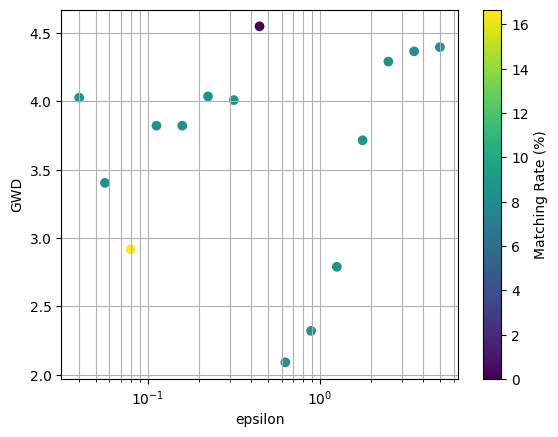

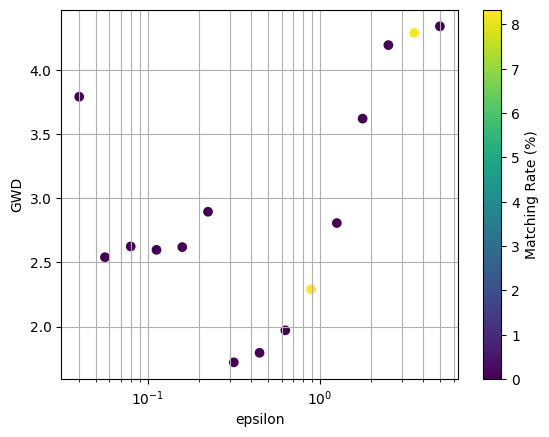

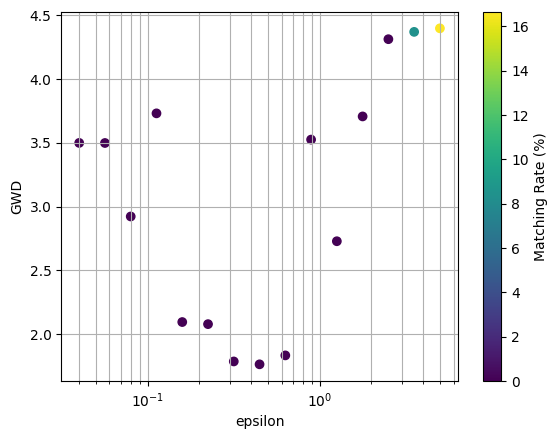

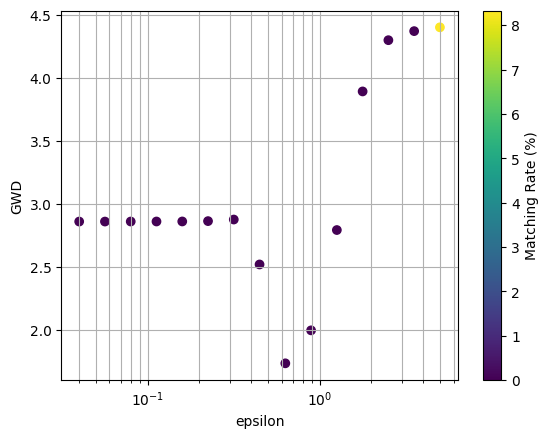

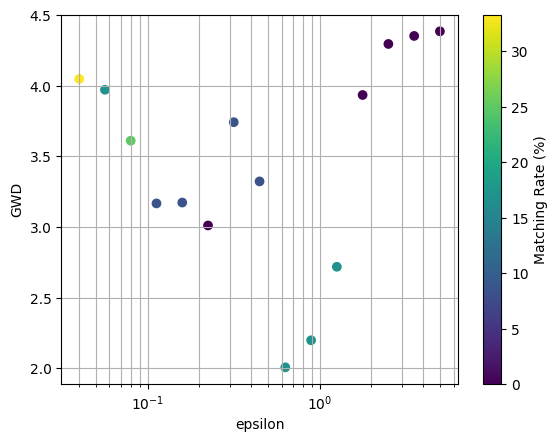

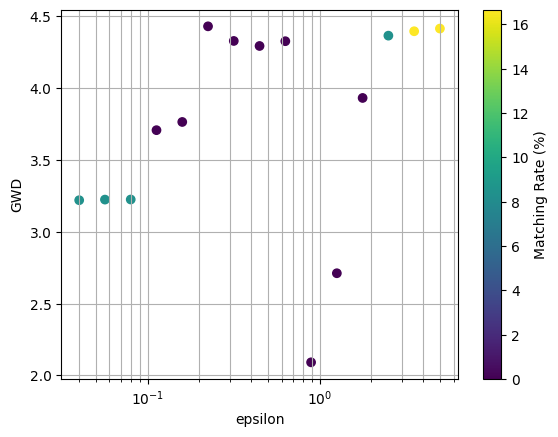

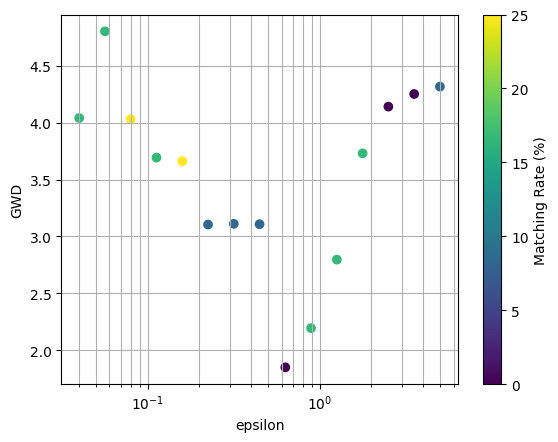

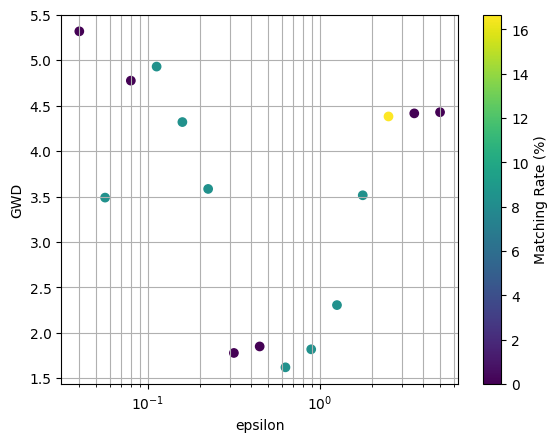

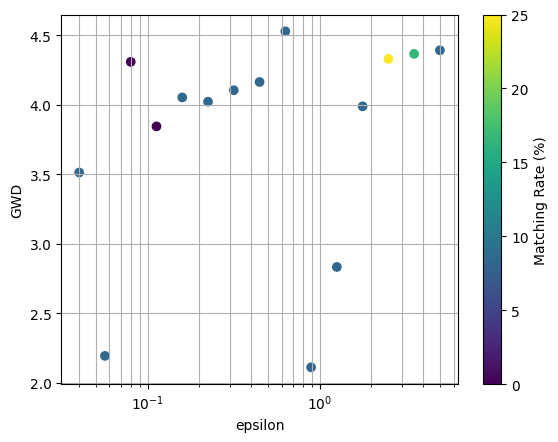

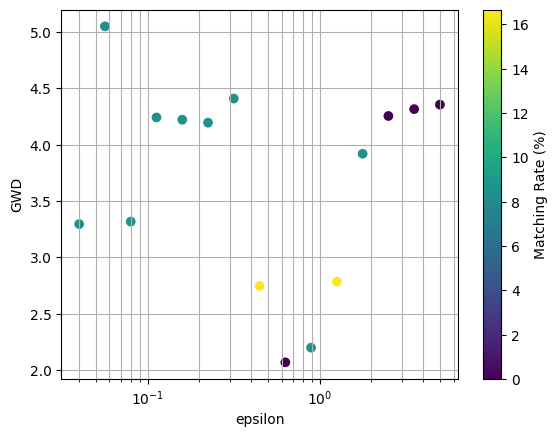

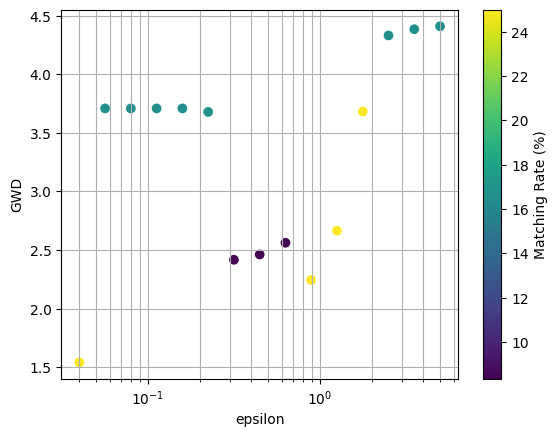

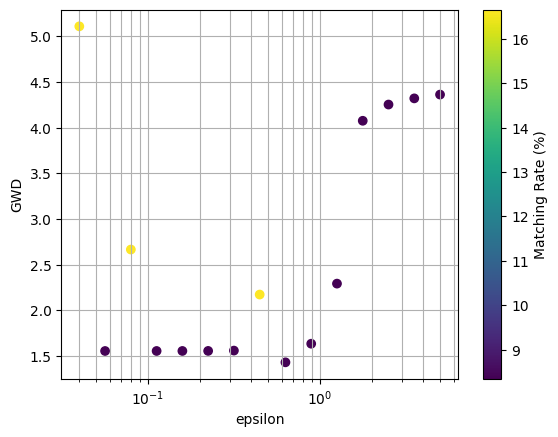

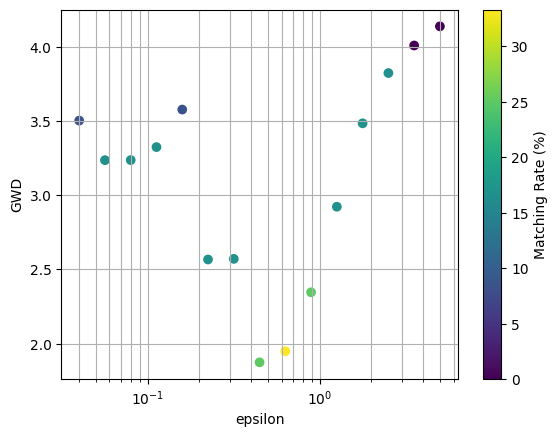

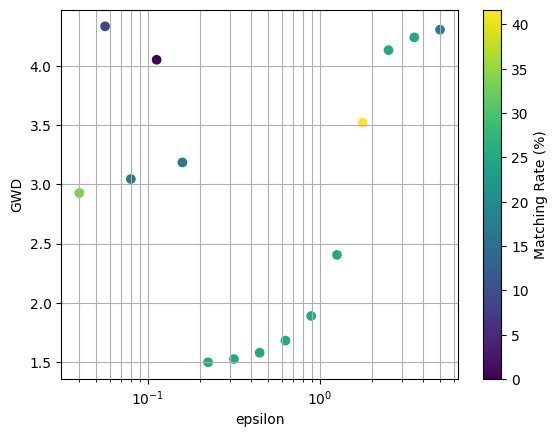

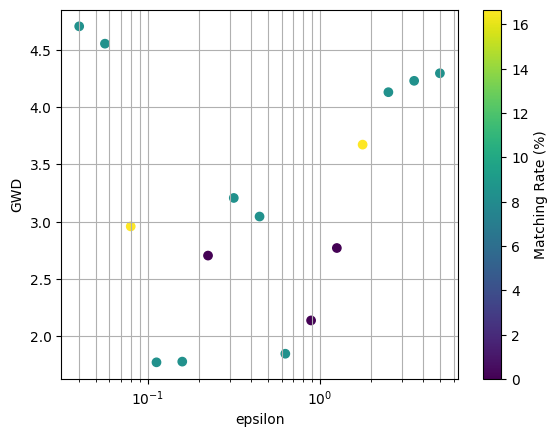

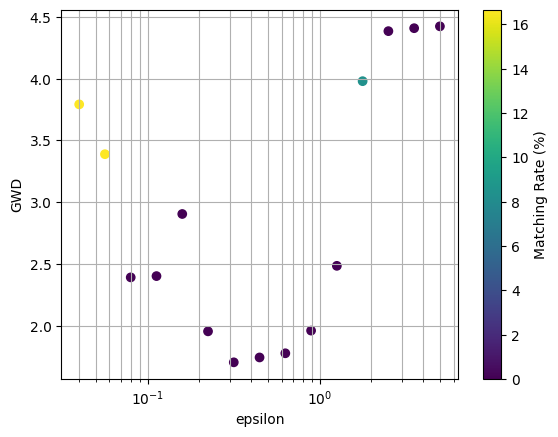

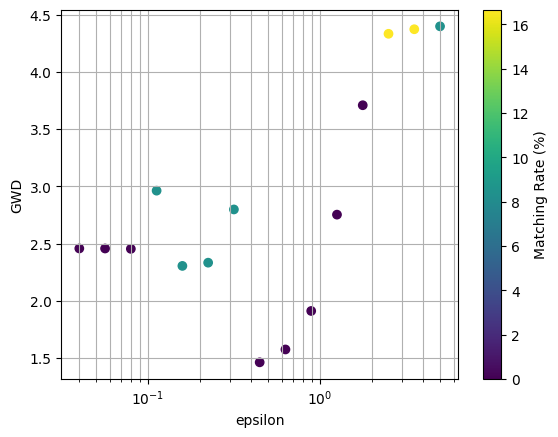

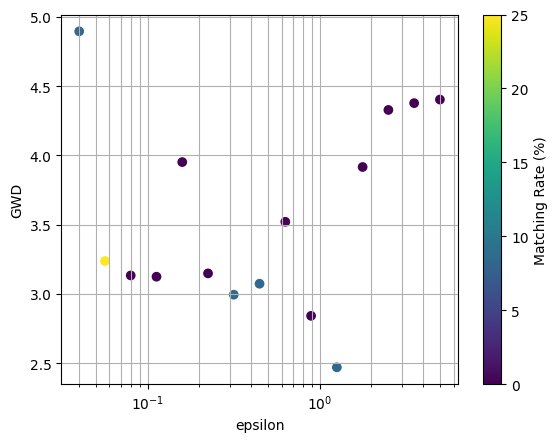

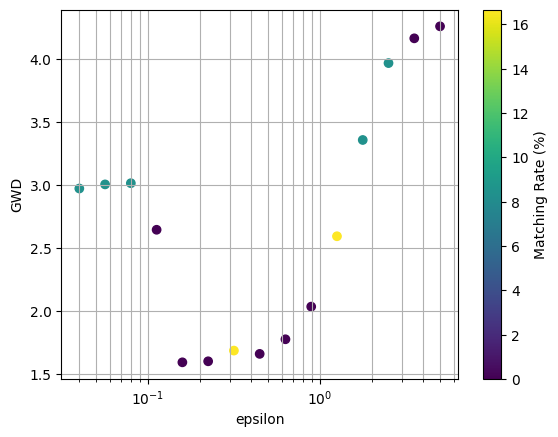

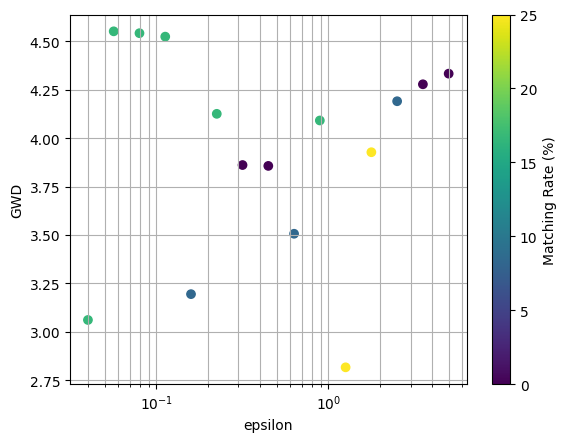

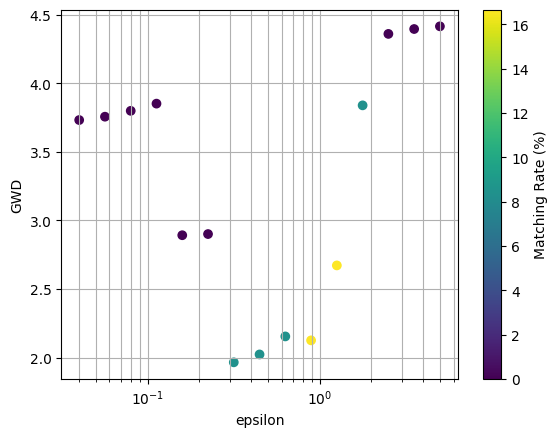

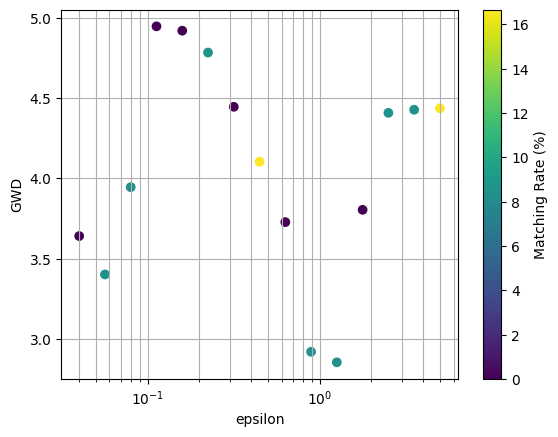

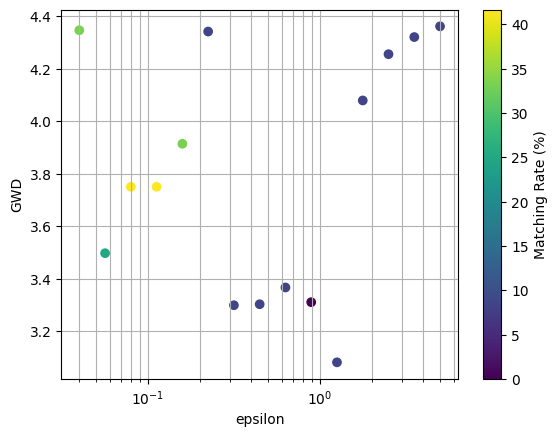

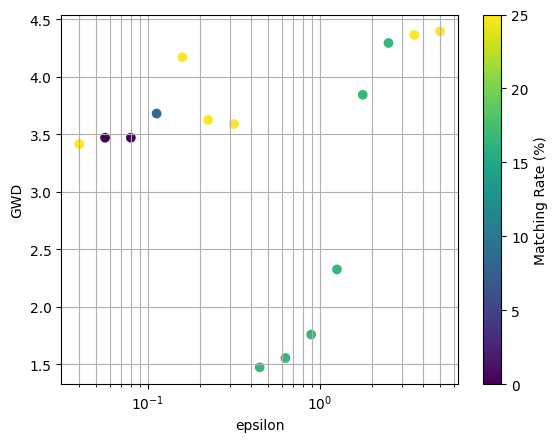

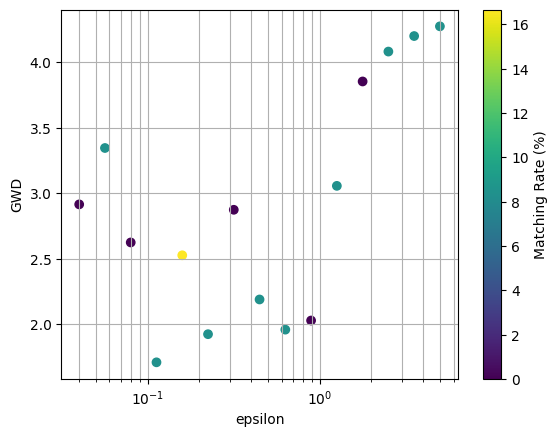

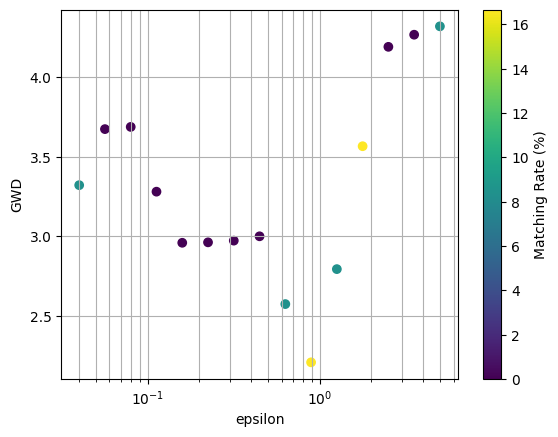

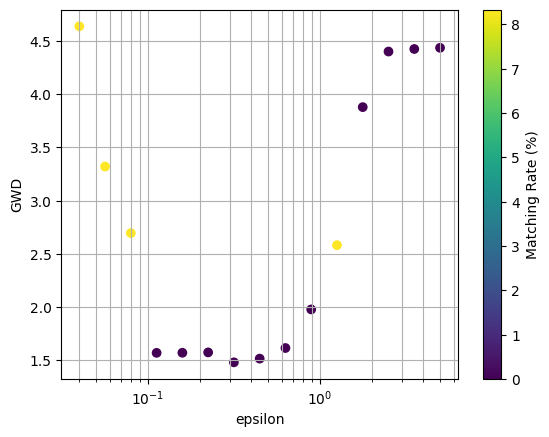

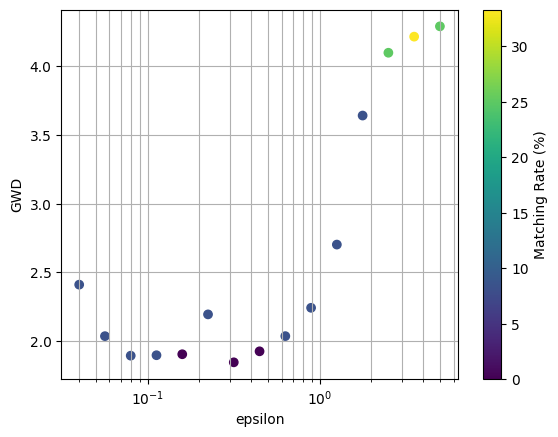

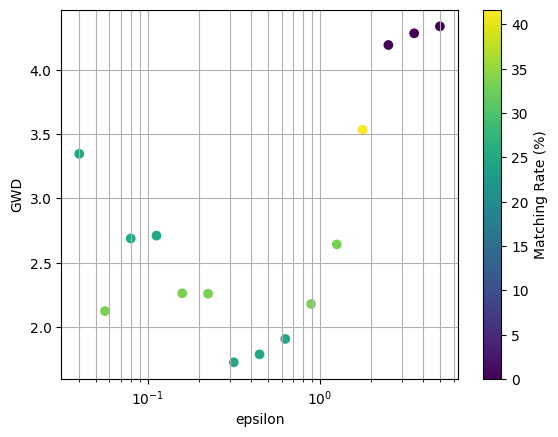

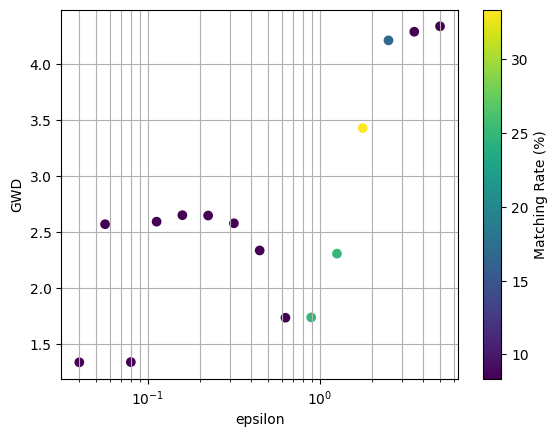

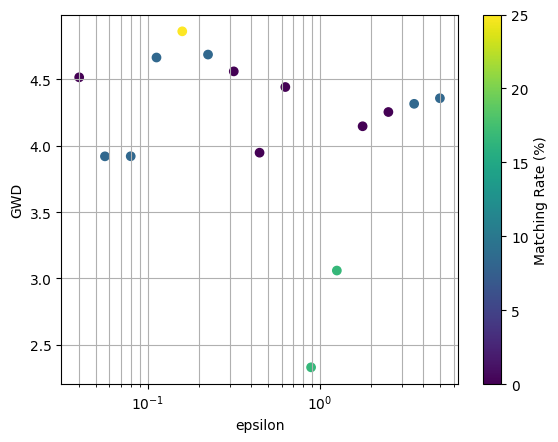

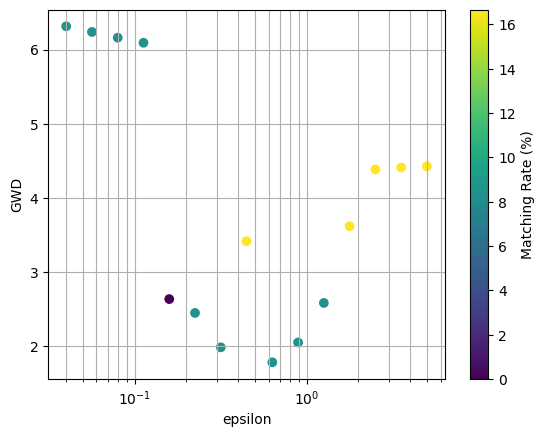

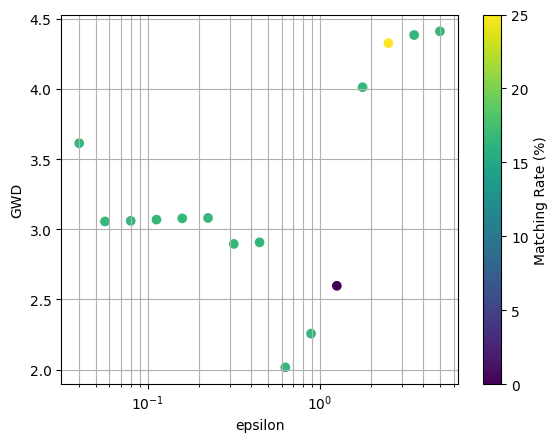

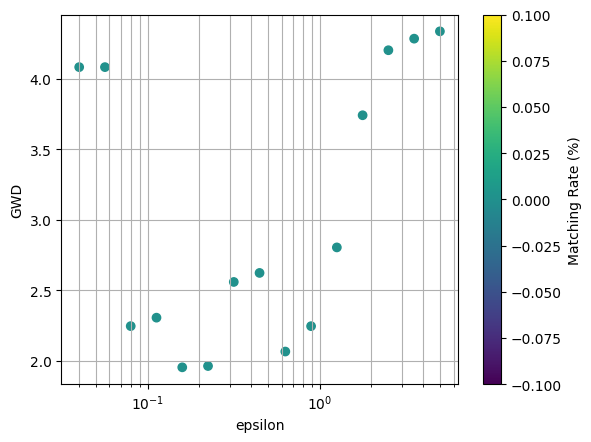

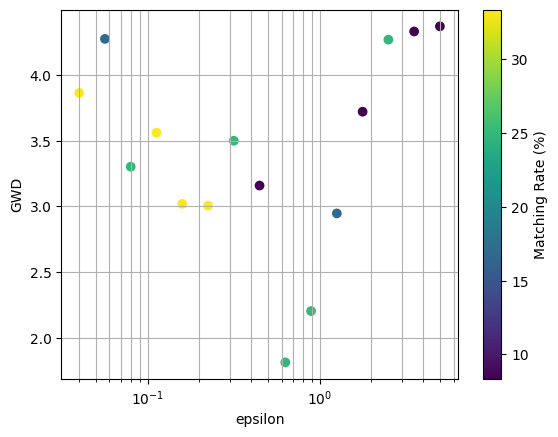

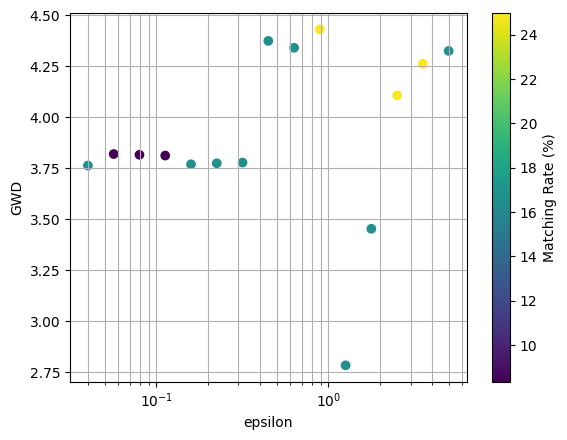

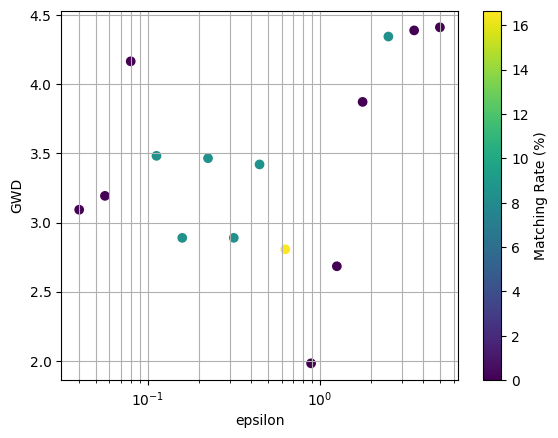

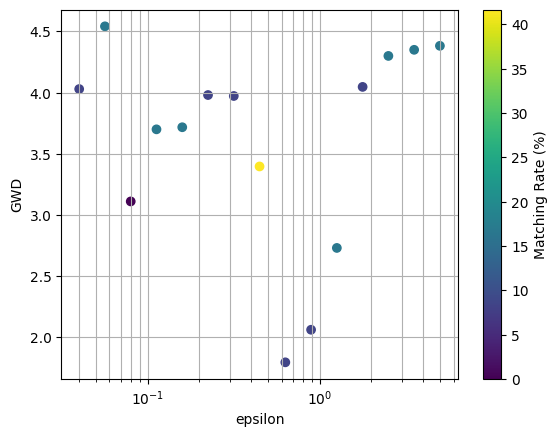

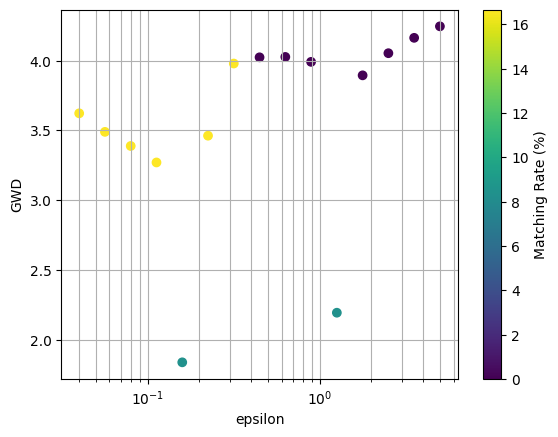

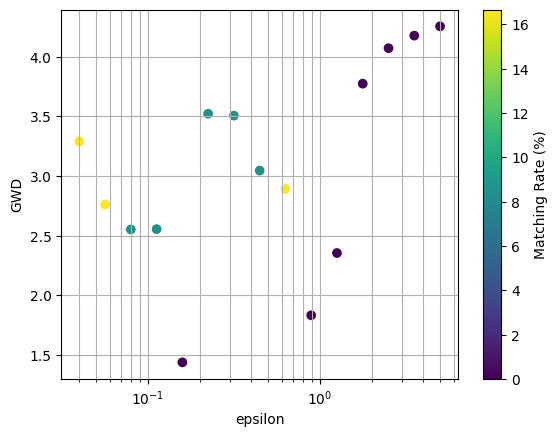

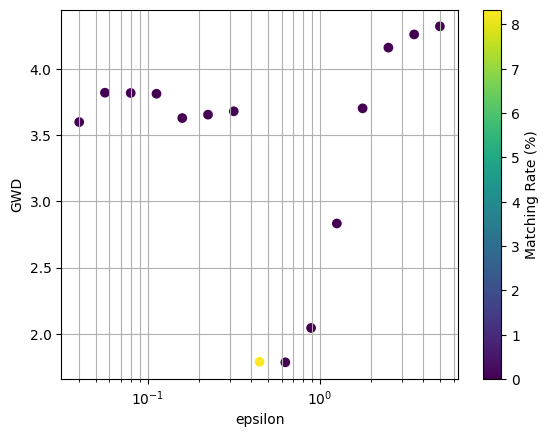

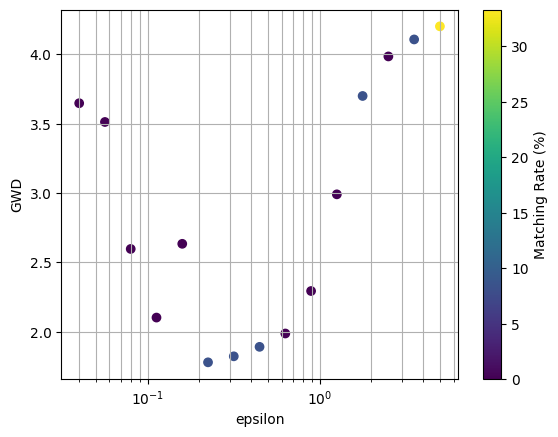

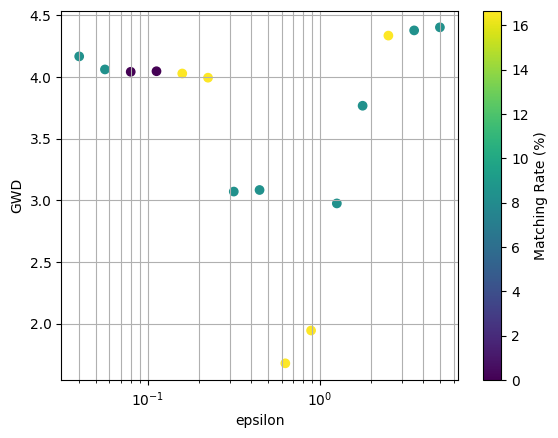

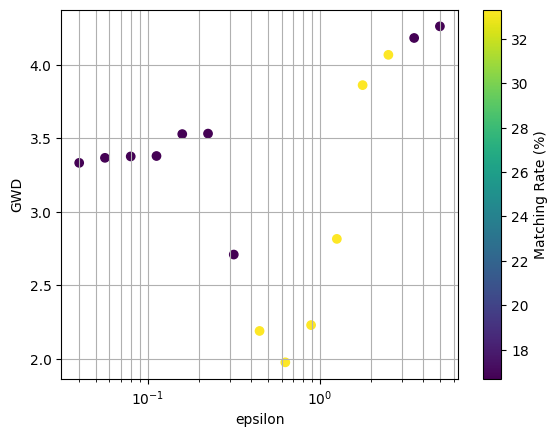

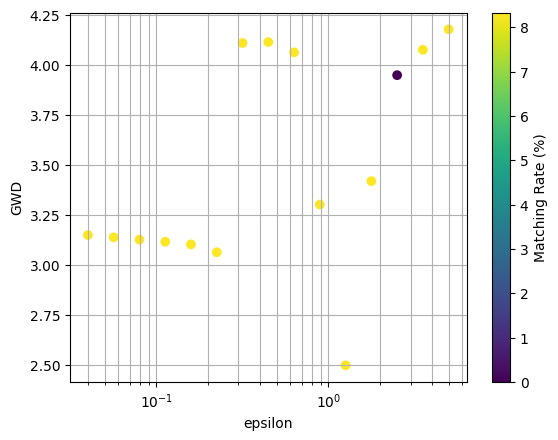

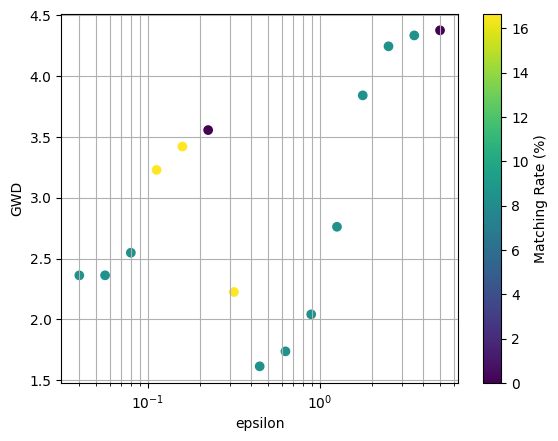

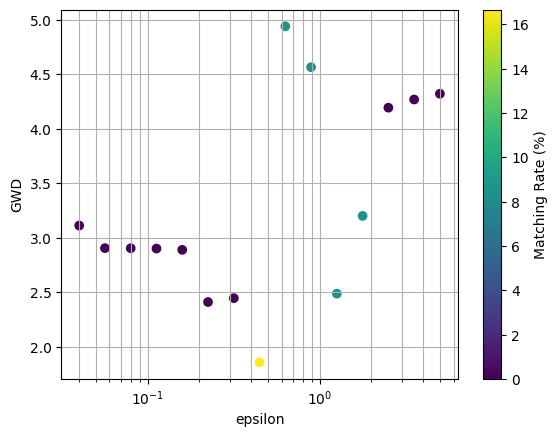

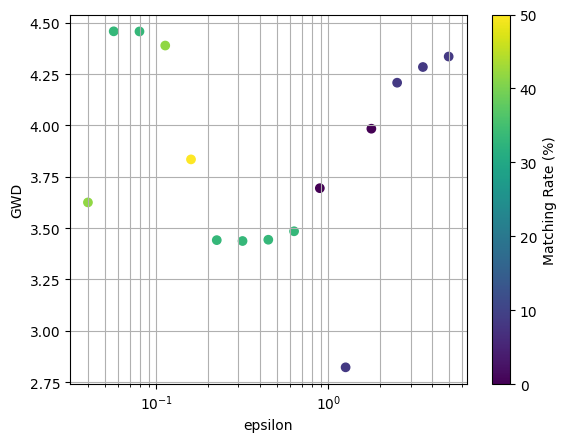

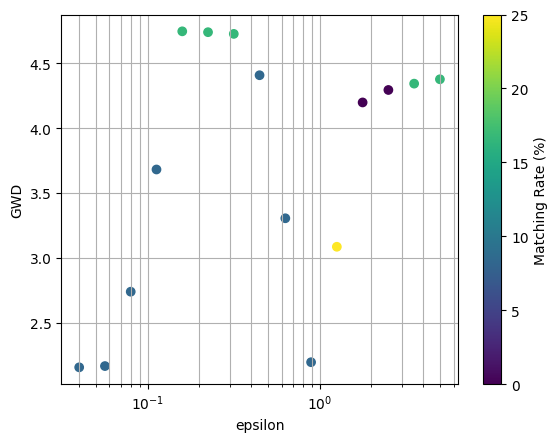

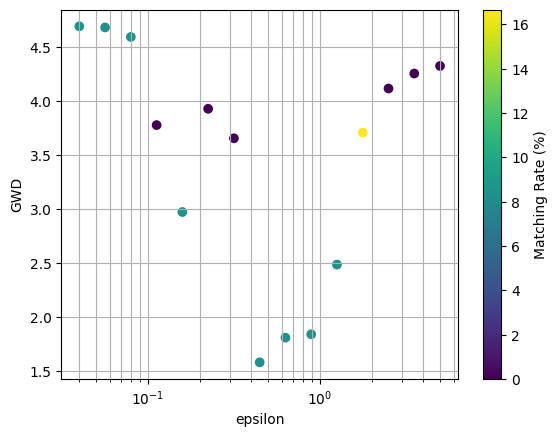

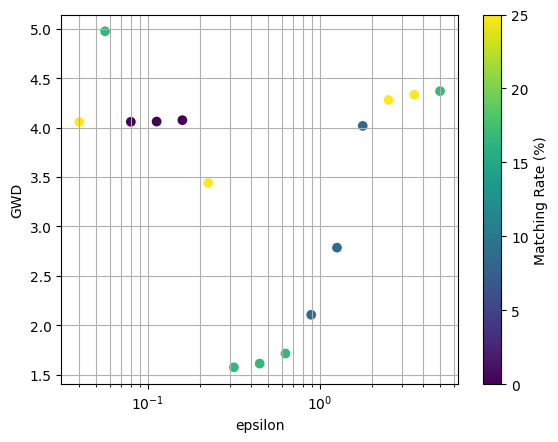

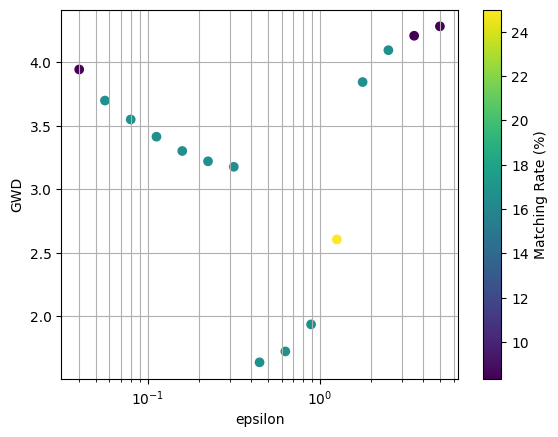

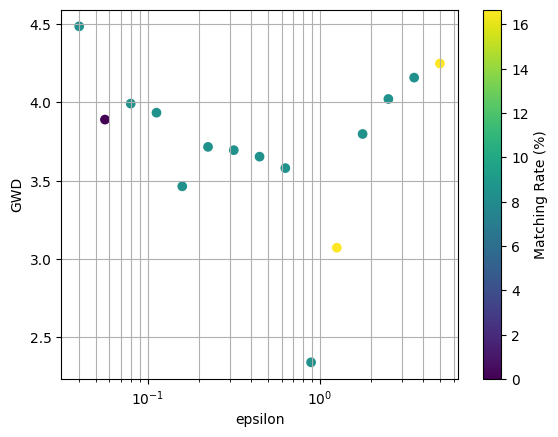

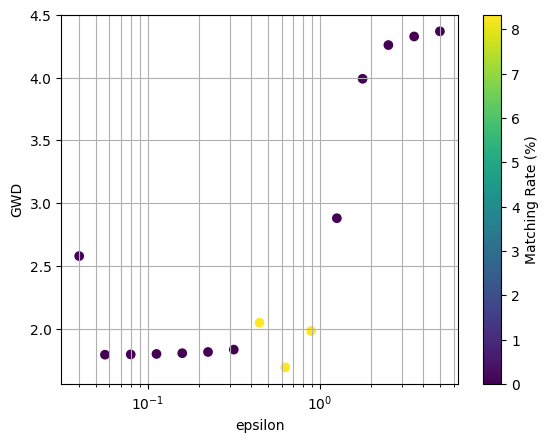

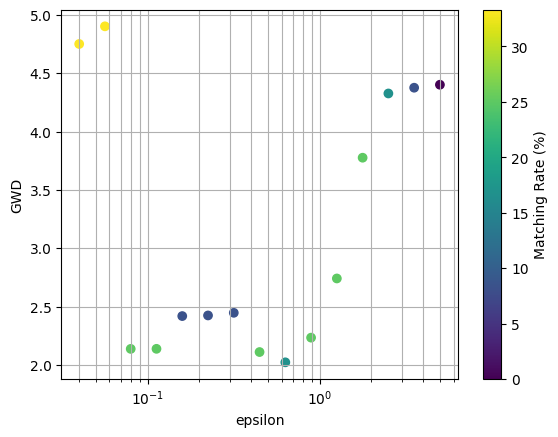

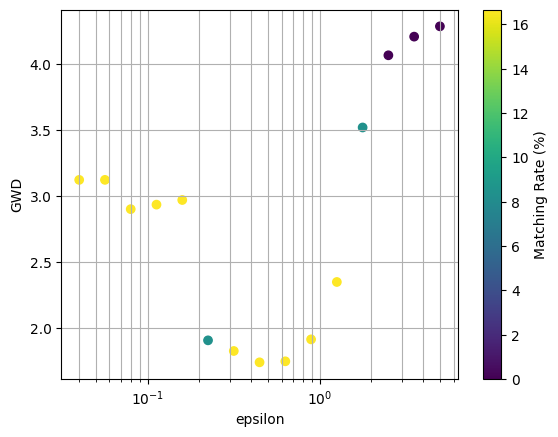

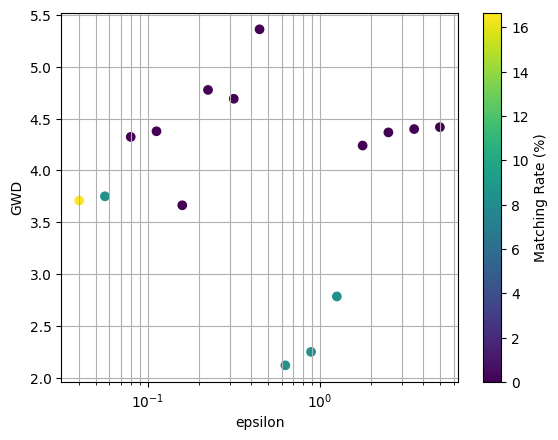

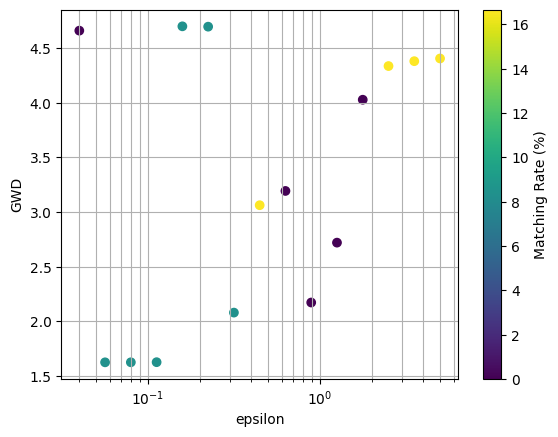

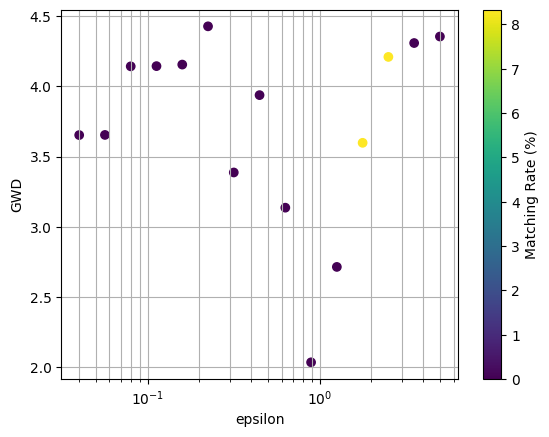

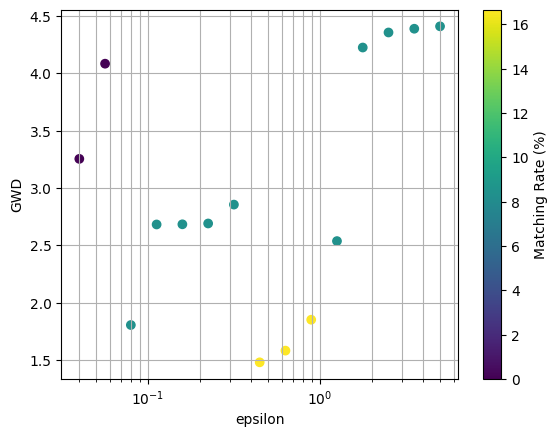

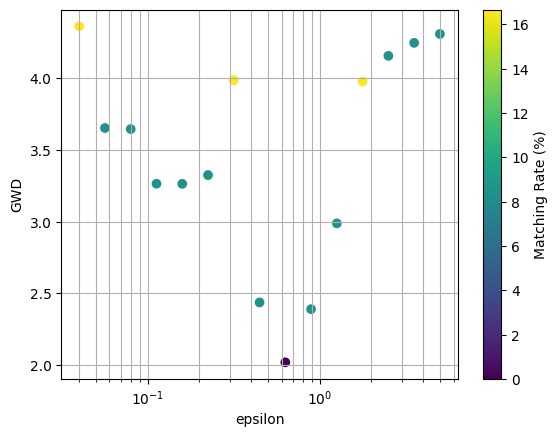

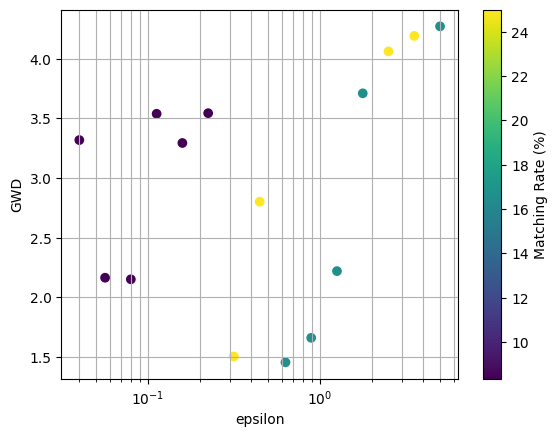

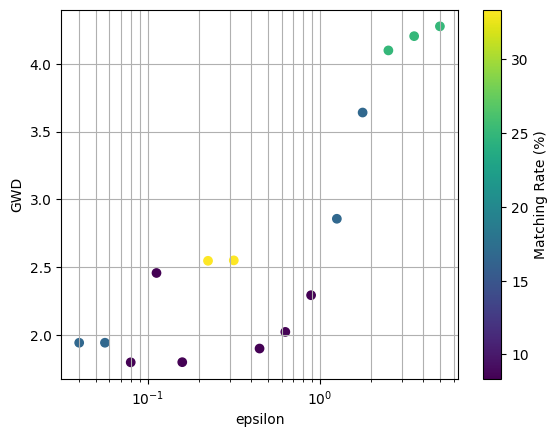

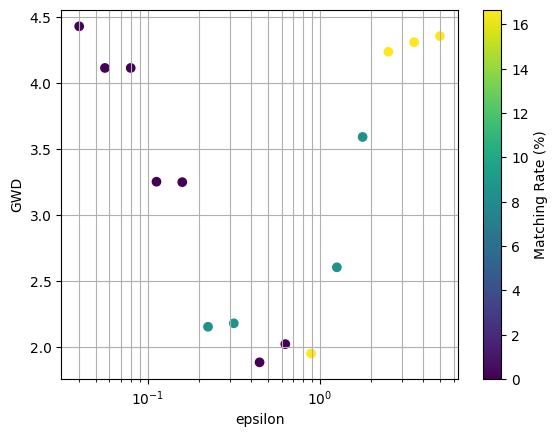

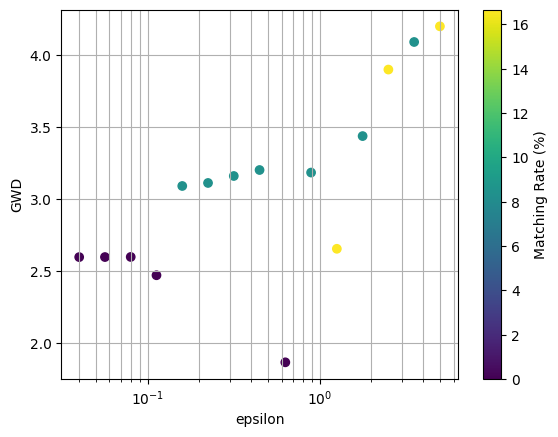

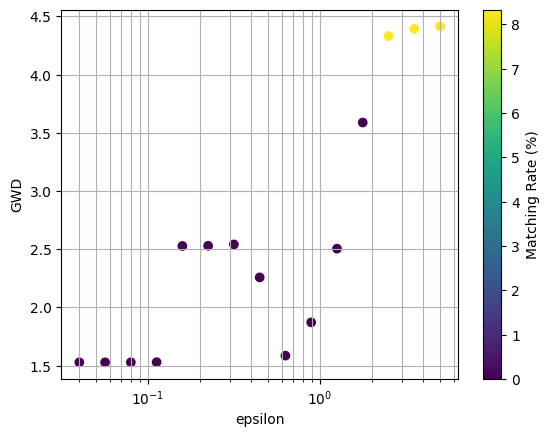

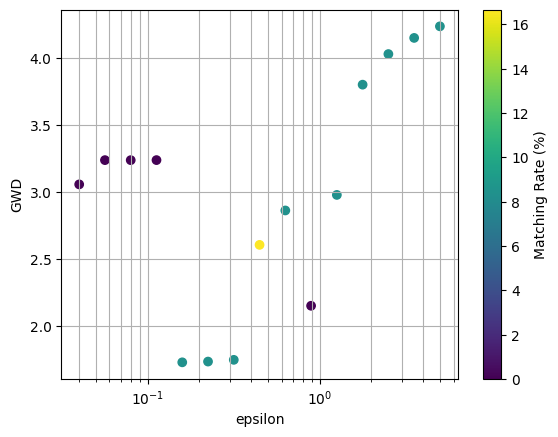

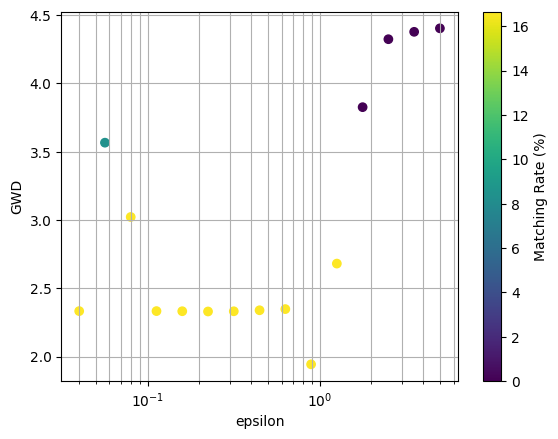

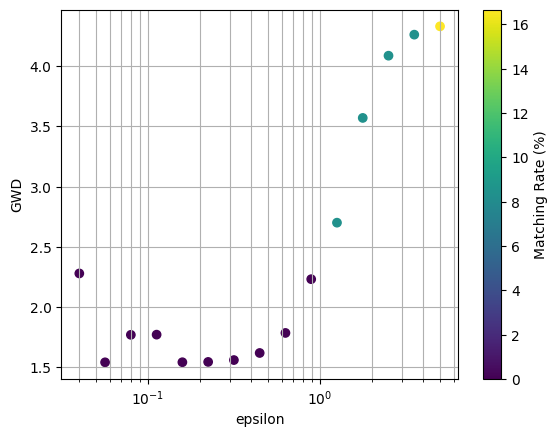

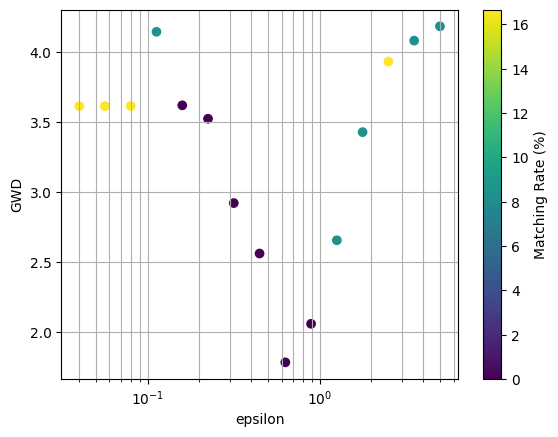

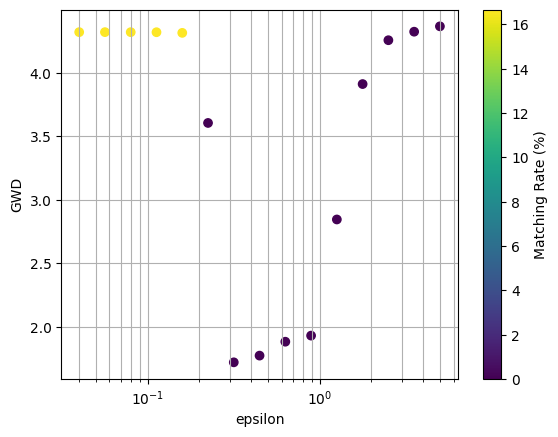

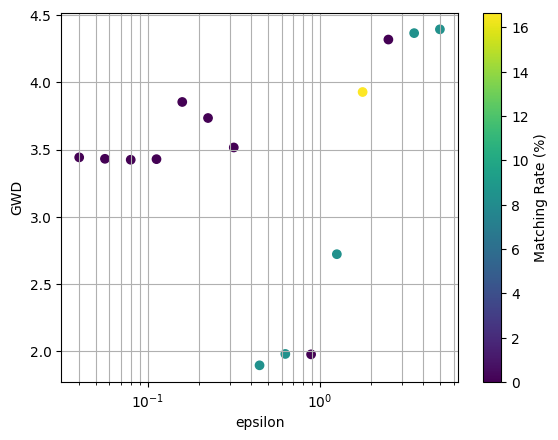

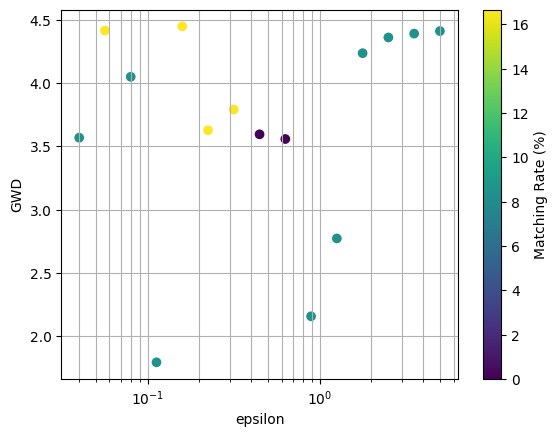

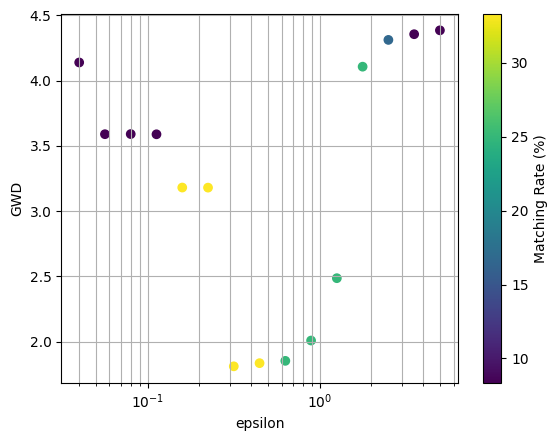

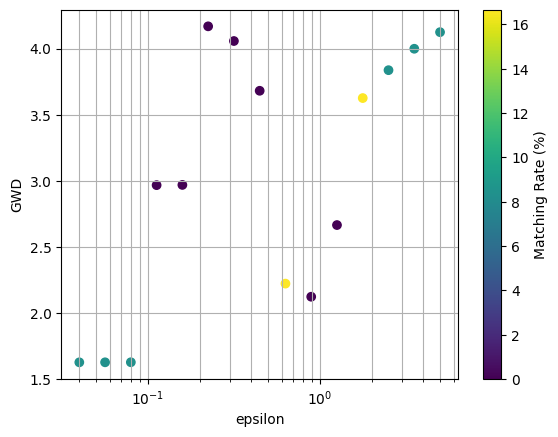

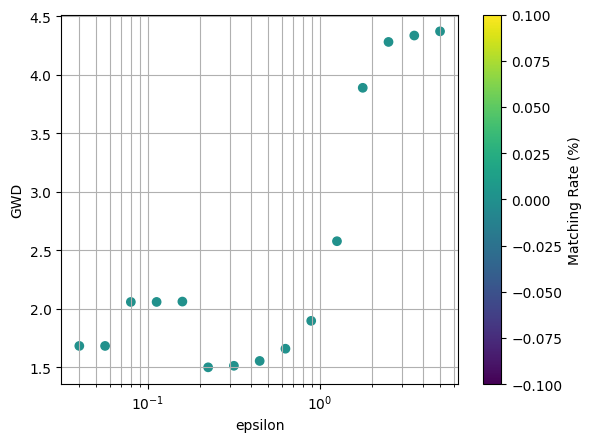

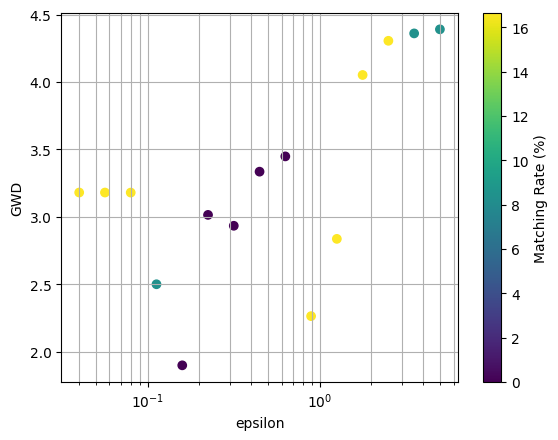

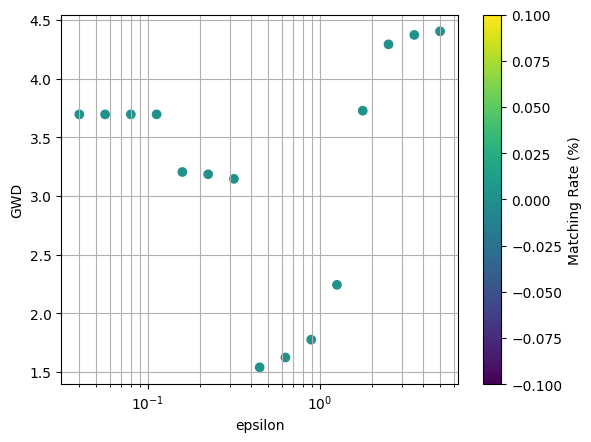

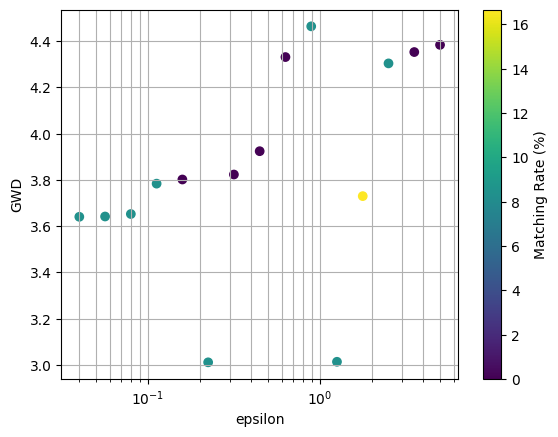

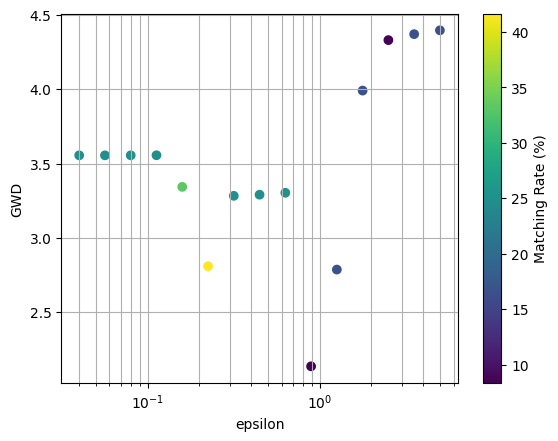

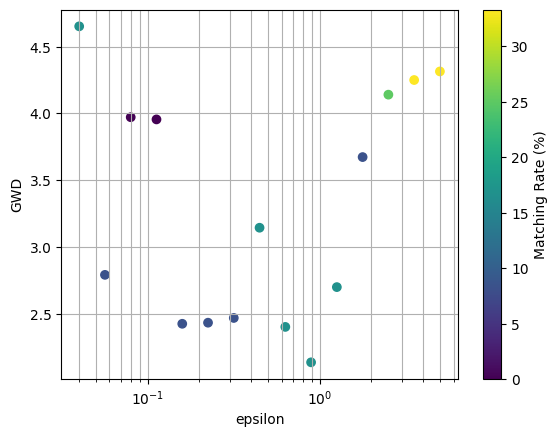

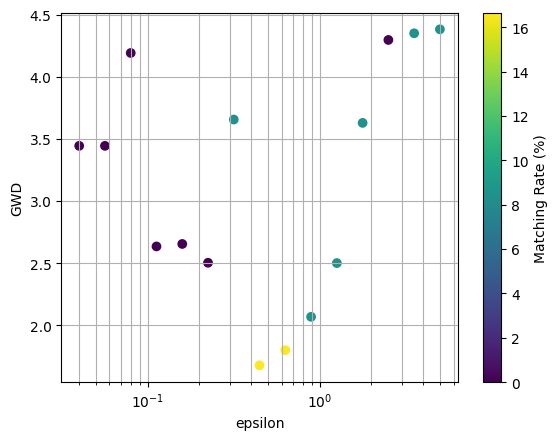

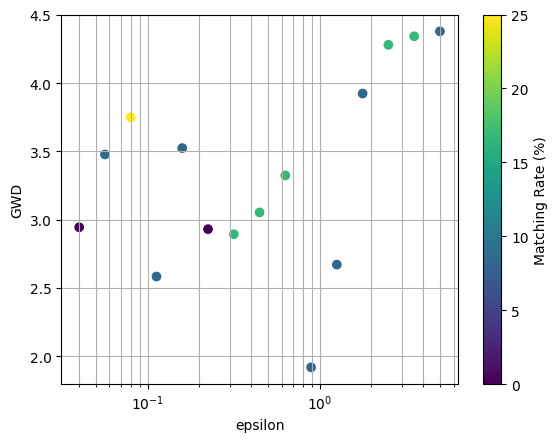

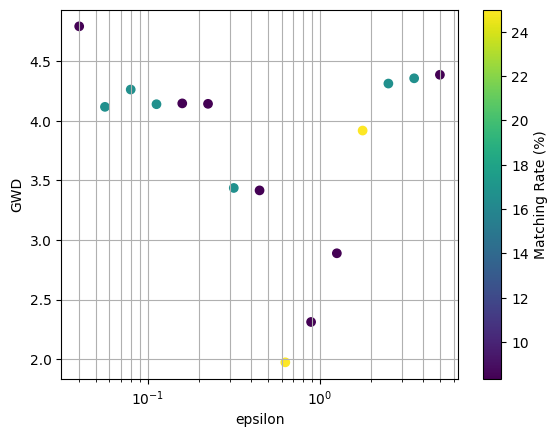

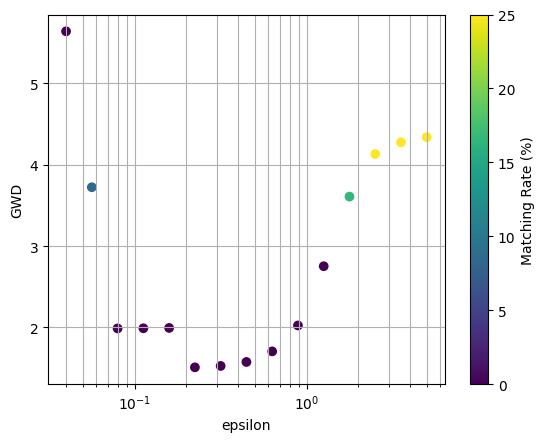

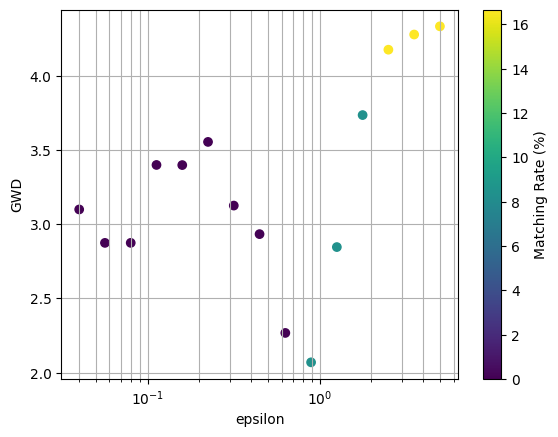

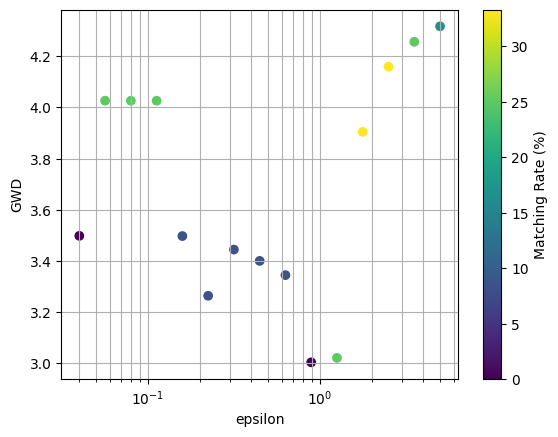

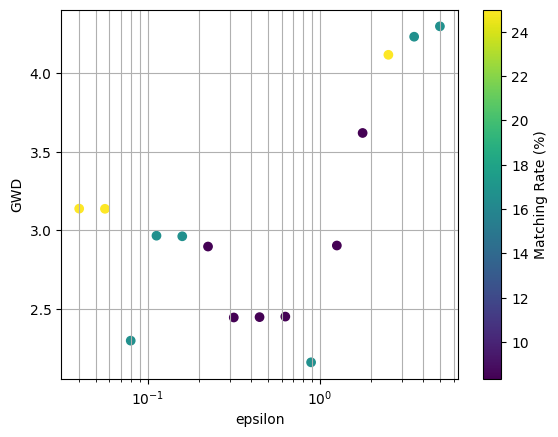

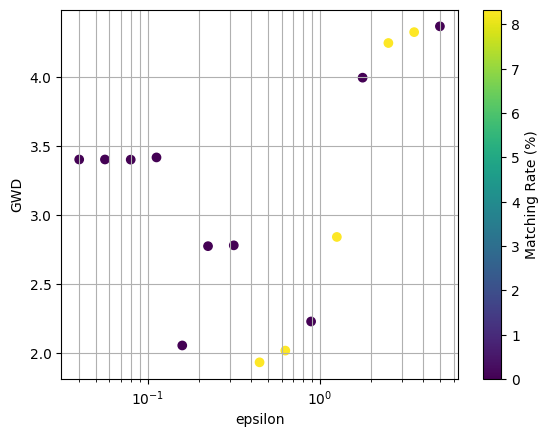

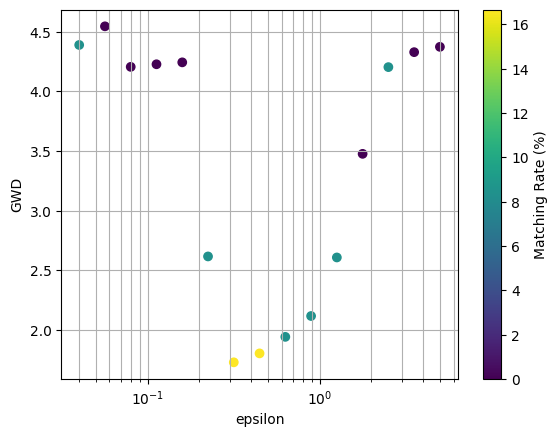

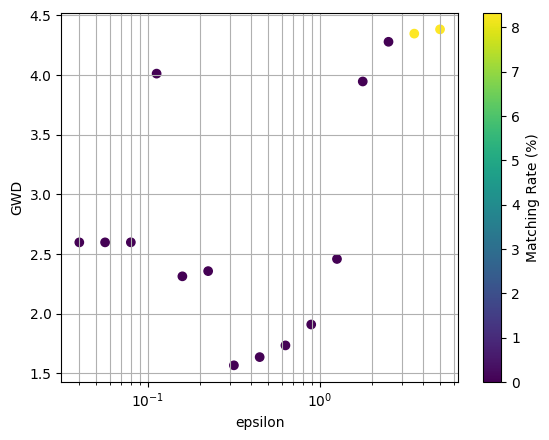

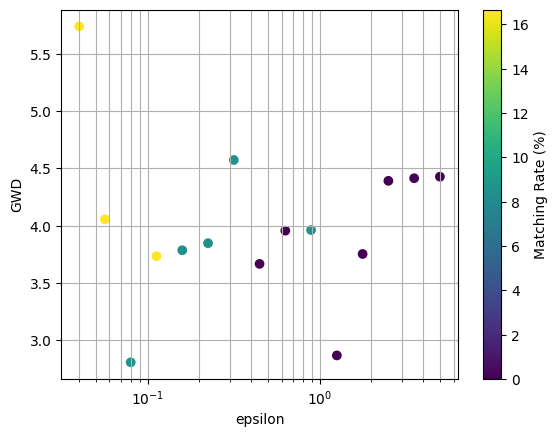

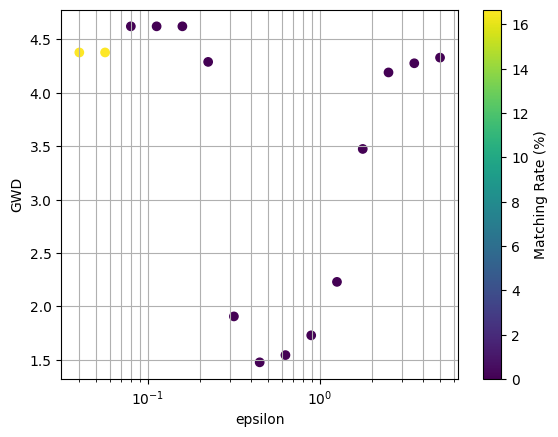

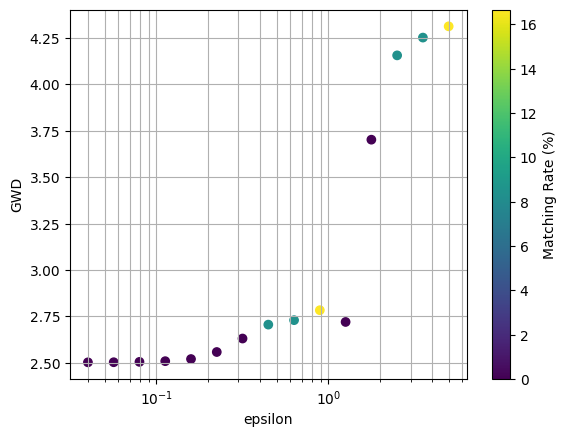

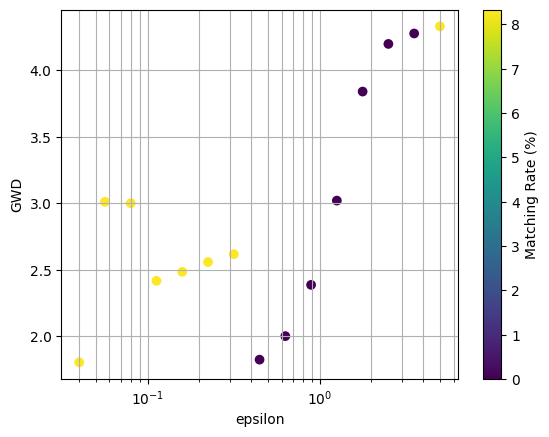

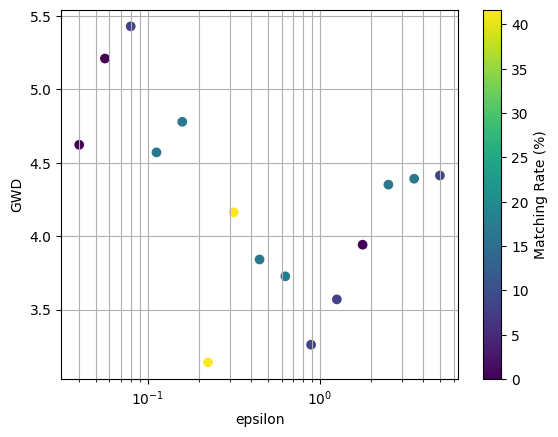

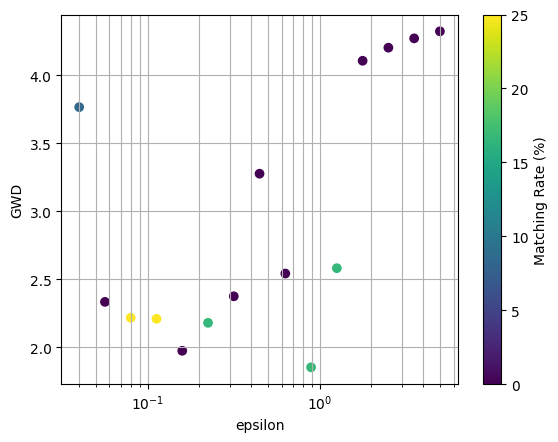

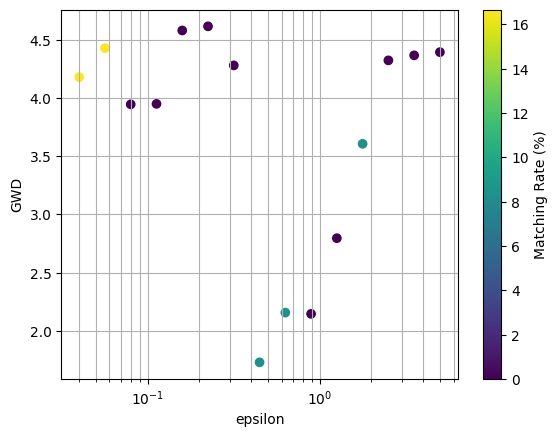

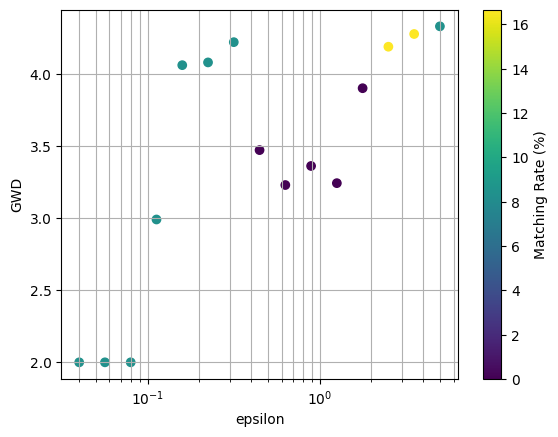

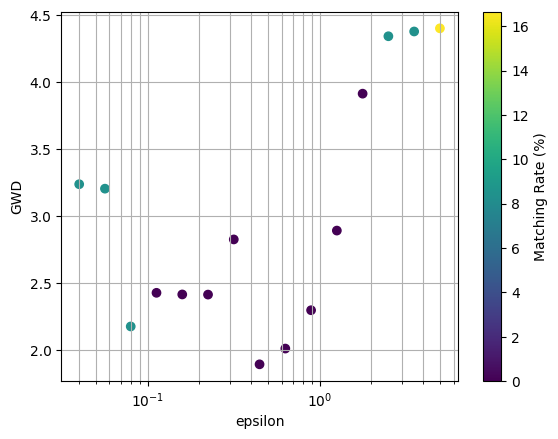

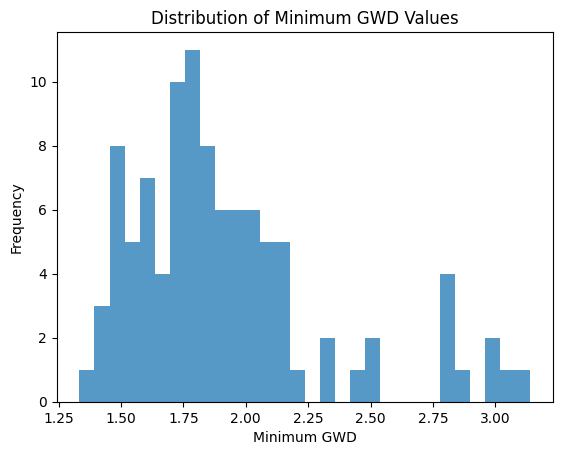

Average Minimum GWD: 1.9201931636398444
Standard Deviation of Minimum GWD: 0.398805813320359


In [ ]:
# Run the process 1000 times
min_gwds = []
for _ in range(100):
    # First shuffling
    value_mapped_raw_shuffledByDiagonal_2_1 = shuffle_upper_triangular_and_asymmetritisize(value_mapped_raw_2.copy(), matrix_size)
    # Second shuffling
    value_mapped_raw_shuffledByDiagonal_2_2 = shuffle_upper_triangular_and_asymmetritisize(value_mapped_raw_2.copy(), matrix_size)

    RSA_corr = RSA(value_mapped_raw_shuffledByDiagonal_2_1, value_mapped_raw_shuffledByDiagonal_2_2)
    print('RSA correlation coefficient : ', RSA_corr) 
    
    # Compute the minimum GWD
    min_gwd = compute_min_gwd(value_mapped_raw_shuffledByDiagonal_2_1, value_mapped_raw_shuffledByDiagonal_2_2, epsilons)
    min_gwds.append(min_gwd)

# Calculate average and standard deviation
avg_min_gwd = np.mean(min_gwds)
std_min_gwd = np.std(min_gwds)

# Plot the distribution of the minimum GWD values
plt.hist(min_gwds, bins=30, alpha=0.75)
plt.title('Distribution of Minimum GWD Values')
plt.xlabel('Minimum GWD')
plt.ylabel('Frequency')
plt.show()

# Print the average and standard deviation
print(f'Average Minimum GWD: {avg_min_gwd}')
print(f'Standard Deviation of Minimum GWD: {std_min_gwd}')

### Distribution of the shuffle to shuffle GWD (column)

#### Kana

RSA correlation coefficient :  0.4557798056552951
RSA correlation coefficient :  0.5264229581954156
RSA correlation coefficient :  0.4480384720619876
RSA correlation coefficient :  0.33453718454654363
RSA correlation coefficient :  0.33152470210825513
RSA correlation coefficient :  0.2342785989035612
RSA correlation coefficient :  0.4708436559975659
RSA correlation coefficient :  0.4292109722501351
RSA correlation coefficient :  0.26012915396485703
RSA correlation coefficient :  0.5256239597009594
RSA correlation coefficient :  0.3051790367112044
RSA correlation coefficient :  0.4635851448337798
RSA correlation coefficient :  0.323344349911505
RSA correlation coefficient :  0.4491995080113754
RSA correlation coefficient :  0.20652440901928115
RSA correlation coefficient :  0.3004706342568948
RSA correlation coefficient :  0.11753534788787827
RSA correlation coefficient :  0.43813490081363204
RSA correlation coefficient :  0.2946555457184485
RSA correlation coefficient :  0.272677120757

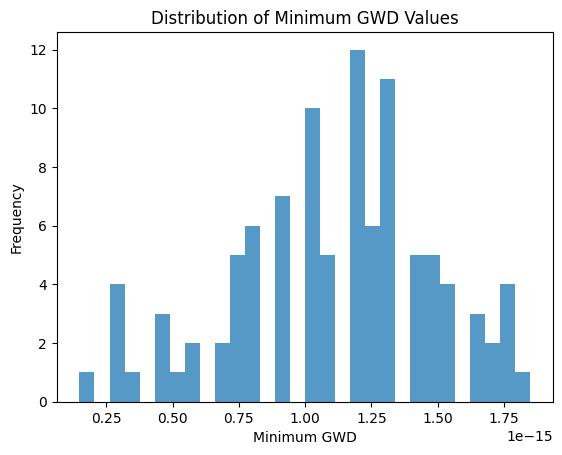

Average Minimum GWD: 1.1109631746280876e-15
Standard Deviation of Minimum GWD: 3.8509005118423336e-16


In [258]:
# Run the process 1000 times
min_gwds = []
for _ in range(100):
    # First shuffling
    value_mapped_as_shuffledByColumn_1_1 = shuffle_column_and_asymmetritisize(value_mapped_raw_1, matrix_size)
    # Second shuffling
    value_mapped_as_shuffledByColumn_1_2 = shuffle_column_and_asymmetritisize(value_mapped_raw_1, matrix_size)

    RSA_corr = RSA(value_mapped_as_shuffledByColumn_1_1, value_mapped_as_shuffledByColumn_1_2)
    print('RSA correlation coefficient : ', RSA_corr)
    
    # Compute the minimum GWD
    min_gwd = compute_min_gwd(value_mapped_as_shuffledByColumn_1_2, value_mapped_as_shuffledByColumn_1_2, epsilons)
    min_gwds.append(min_gwd)

# Calculate average and standard deviation
avg_min_gwd = np.mean(min_gwds)
std_min_gwd = np.std(min_gwds)

# Plot the distribution of the minimum GWD values
plt.hist(min_gwds, bins=30, alpha=0.75)
plt.title('Distribution of Minimum GWD Values')
plt.xlabel('Minimum GWD')
plt.ylabel('Frequency')
plt.show()

# Print the average and standard deviation
print(f'Average Minimum GWD: {avg_min_gwd}')
print(f'Standard Deviation of Minimum GWD: {std_min_gwd}')

#### Angus

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning:

Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.



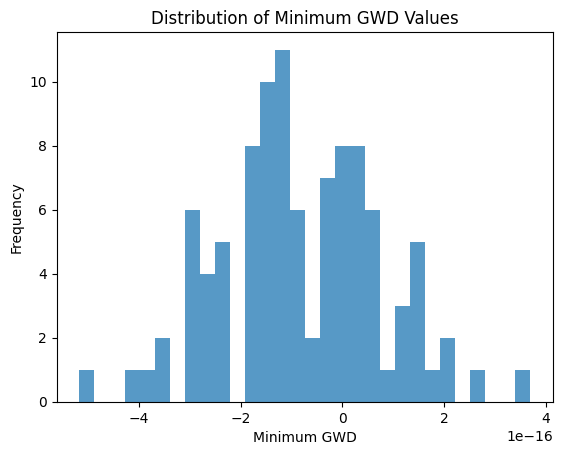

Average Minimum GWD: -7.845548654239495e-17
Standard Deviation of Minimum GWD: 1.5744594293134765e-16


In [ ]:
# Run the process 1000 times
min_gwds = []
for _ in range(100):
    # First shuffling
    value_mapped_as_shuffledByColumn_2_1 = shuffle_column_and_asymmetritisize(value_mapped_raw_2, matrix_size)
    # Second shuffling
    value_mapped_as_shuffledByColumn_2_2 = shuffle_column_and_asymmetritisize(value_mapped_raw_2, matrix_size)
    
    RSA_corr = RSA(value_mapped_as_shuffledByColumn_2_1, value_mapped_as_shuffledByColumn_2_2)
    print('RSA correlation coefficient : ', RSA_corr)

    # Compute the minimum GWD
    min_gwd = compute_min_gwd(value_mapped_as_shuffledByColumn_2_2, value_mapped_as_shuffledByColumn_2_2, epsilons)
    min_gwds.append(min_gwd)

# Calculate average and standard deviation
avg_min_gwd = np.mean(min_gwds)
std_min_gwd = np.std(min_gwds)

# Plot the distribution of the minimum GWD values
plt.hist(min_gwds, bins=30, alpha=0.75)
plt.title('Distribution of Minimum GWD Values')
plt.xlabel('Minimum GWD')
plt.ylabel('Frequency')
plt.show()

# Print the average and standard deviation
print(f'Average Minimum GWD: {avg_min_gwd}')
print(f'Standard Deviation of Minimum GWD: {std_min_gwd}')